### Загрузка данных и общий обзор

In [1]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from scipy.stats import mode
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import graph_objects as go 
import phik
from scipy import stats as st
plt.rcParams["figure.figsize"] = (20,10)

In [3]:
# bc - bank clients
bc = pd.read_csv('https://code.s3.yandex.net/datasets/bank_scrooge.csv')
bc.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [4]:
bc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


#### Выводы по разделу

Первый взгляд на данные сделан, всего в таблице bank_scrooge представлена информация о 10 тысячах клиентов банка. В таблице 12 столбцов, позже мы рассмотрим каждый столбец в отдельности, проанализируем и исследуем имеющиеся данные. Пока обращаем внимание, что название столбцов различаются по регистру написания и есть пропуски в столбцах age и balance.

### Предобработка данных

#### Проверить корректность наименований колонок

Приведем все столбцы к единому регистру

In [5]:
bc.columns = bc.columns.str.lower()

Добавим разделение, в название столбца userid

In [6]:
bc = bc.rename(columns={'userid': 'user_id'})

#### Исследовать соответствие типов

In [7]:
bc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  est_salary     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


Типы данных столбцов, соответствуют содержащимся в них данным

#### Исследовать пропущенные значения

Ранее нами выявлено, что в двух столбцах имееются пропущенные значения. Рассмотрим каждый из них в отдельности и примем решение, как быть с пропусками. Для начала определим долю пропущенных значений

In [8]:
pd.DataFrame(round(bc.isna().mean().sort_values(ascending=False)*100,1))\
.style.background_gradient('coolwarm')

,0
balance,23.000000
age,0.300000
user_id,0.000000
score,0.000000
city,0.000000
gender,0.000000
equity,0.000000
products,0.000000
credit_card,0.000000
last_activity,0.000000


**age**

Согласно общепринятой классификации пропусков, отнесем пропуски в столбце age к механизму MCAR, вероятность пропуска для каждой записи набора одинакова, в таком случае игнорирование/исключение записей, содержащих пропущенные данные, не ведет к искажению результатов.

In [9]:
bc['age_pass'] = bc['age'].isna()

In [10]:
age_pass_pivot = bc.pivot_table( columns='age_pass',
                                    values=('est_salary','balance','products','equity','churn','city','gender'),
                                    aggfunc=({'est_salary':'mean','balance':'mean','products': 'median',
                                              'equity':'median','churn':'sum','city':pd.Series.mode,
                                              'gender':pd.Series.mode}))
age_pass_pivot

age_pass,False,True
balance,827245.587515,1250033.573
churn,1819,1
city,Ярославль,Ярославль
equity,3,0
est_salary,147786.809731,178585.199231
gender,М,М
products,2,1


Доля пропущенных значений в столбце менее 0.5%, также, среди клиентов для которых есть проущенные значения в столбце age только один клиент является отточным, несмотря на то что значение меры средних отличаются для ряда признаков, обработка значений не требуется, т.к. доля пропусков 0.3% низкая, на результат исследования не окажет влияния. 

**balance**

Доля пропущенных значений составляет порядка 23% от общего числа. Перед принятием решения, как с ними поступить, попробуем определить зависимость остальных признаков от этого. Для анализа, определим новый признак с булевым значением, где True будет означать - пропуск есть, False - пропуска нет. Используя данные нового признака, подготовим сводную таблицу, с расчетом средних, медианных и других значений для сравнения двух выборок

In [11]:
bc['balance_pass'] = bc['balance'].isna()
bc.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_pass,balance_pass
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,False,False
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,False,False
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,False,True
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,False,False
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,False,False


In [12]:
balance_pass_pivot = bc.pivot_table( columns='balance_pass',
                                    values=('age','est_salary','products','equity','churn','city','gender'),
                                    aggfunc=({'age': 'mean', 'est_salary':'mean','products': 'median',
                                              'equity':'median','churn':'sum','city':pd.Series.mode,
                                              'gender':pd.Series.mode}))
balance_pass_pivot

balance_pass,False,True
age,42.924366,42.093023
churn,1807,13
city,Ярославль,Ярославль
equity,4,0
est_salary,124501.872366,226310.208654
gender,Ж,М
products,2,1


Подведем итог исследования зависимости других признаком от пропусков в балансе, замечено отличие двух выборок по среднему количеству собственности, медианой зарплате, количеству продуктов и гендерному признаку. 
Согласно общепринятой классификации пропусков, отнесем пропуски в столбце balance к механизму MNAR, пропуски зависят от данных, без дополнительного обоснования их нельзя отбрасывать или заполнять одним значением, т.к. это приведёт к заметным искажениям. 

Факты - клиенты для которых значение баналса пропущено приемущественно мужчины, с более высокой заработной платой, меньшим количеством продуктов и полным отсутствием собственности, также среди них очень мало отточных. Можно предположить, что возможно это клиенты у которых нет счета для учета баланса или он арестован/находится в блокировке, это предположение косвенно подтверждается отсутствием собственности (конфискация), также возможно это новые клиенты, т.к. очень мало отточных, а сведения о балансе возможно не успели попасть выборку из за отражения более поздним числом. Еще одна версия - это кредитные/ипотечные клиенты, у которых есть приемущественно 1 продукт, который еще не является их собственностью. 

Решение: удаление строк может привести к тому, что при дальнейших вычислениях используется не вся доступная информация, стандартные отклонения возрастают, полученные результаты становятся менее репрезентативными, примем к сведению и оставим пропуски как есть.

#### Исследовать дубликаты

In [13]:
bc.duplicated().sum()

0

Явные дубликаты строк отсутствуют

Поищем неявные дубликаты в столбце user_id

In [14]:
bc[bc[['user_id']].duplicated(keep=False)].head()


,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_pass,balance_pass
7,218868,825.0,Ярославль,Ж,38.0,4,458145.40,2,1,1,68085.48,0,False,False
58,164676,860.0,Ярославль,М,37.0,5,648594.03,2,1,1,213586.86,1,False,False
150,185748,850.0,Рыбинск,М,36.0,5,1203376.67,2,0,1,89401.82,1,False,False
161,197364,928.0,Рыбинск,Ж,53.0,6,1347183.86,2,0,1,168189.49,1,False,False
231,190253,823.0,Рыбинск,М,37.0,4,373348.39,2,0,1,131947.92,1,False,False


In [15]:
bc.query('user_id==218868')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_pass,balance_pass
7,218868,825.0,Ярославль,Ж,38.0,4,458145.40,2,1,1,68085.48,0,False,False
5470,218868,827.0,Рыбинск,Ж,NaN,4,448959.07,2,1,1,67835.95,0,True,False


In [16]:
bc.query('user_id==164676')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_pass,balance_pass
58,164676,860.0,Ярославль,М,37.0,5,648594.03,2,1,1,213586.86,1,False,False
7271,164676,790.0,Рыбинск,Ж,77.0,1,111202.01,1,1,0,32835.45,0,False,False


In [17]:
bc.query('user_id==185748')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_pass,balance_pass
150,185748,850.0,Рыбинск,М,36.0,5,1203376.67,2,0,1,89401.82,1,False,False
3106,185748,912.0,Ярославль,Ж,47.0,5,1598218.98,2,0,0,180256.98,0,False,False


In [18]:
bc.query('user_id==197364')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_pass,balance_pass
161,197364,928.0,Рыбинск,Ж,53.0,6,1347183.86,2,0,1,168189.49,1,False,False
4870,197364,889.0,Ярославль,М,33.0,0,NaN,2,1,1,96173.48,0,False,True


In [19]:
bc.query('user_id==190253')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_pass,balance_pass
231,190253,823.0,Рыбинск,М,37.0,4,373348.39,2,0,1,131947.92,1,False,False
1583,190253,726.0,Ярославль,М,49.0,0,NaN,1,1,1,177700.78,0,False,True


Посмотрели на 5 первых записи, по всем признакам это все таки разные клиенты, обращает внимание что как правило это клиенты из разных городов Ярославль и Рыбинск, можно предположить что произошло дублирование счетчиков и разные клиенты попали в выгрузку под одним идентификатором. Удалять дубли не будем, т.к. в расчетах не планируем использовать признак user_id, а остальные данные, как от разных клиентов, нам пригодятся.

#### Вывод по разделу

В ходе предобработки нами была проведена проверка на дубликаты в данных, явные и неявные, выявленj 146 дублирующих значений в столбце user_id, по всем признакам это разные клиенты, обращает внимание что как правило это клиенты из разных городов Ярославль и Рыбинск, можно предположить что произошло дублирование счетчиков и разные клиенты попали в выгрузку под одним идентификатором. Удалять дубли не будем, т.к. в расчетах не планируем использовать признак user_id, а остальные данные, как от разных клиентов, нам пригодятся.

Выполнили приведение столбцов к единому регистру и добавили разделитель в столбце user_id

В ходе исследования зависимости других признаком от пропусков в балансе, замечено отличие двух выборок по среднему количеству собственности, медианой зарплате, количеству продуктов и гендерному признаку. Факты - клиенты для которых значение баналса пропущено приемущественно мужчины, с более высокой заработной платой, меньшим количеством продуктов и полным отсутствием собственности, также среди них очень мало отточных. Можно предположить, что возможно это клиенты у которых нет счета для учета баланса или он арестован/находится в блокировке, это предположение косвенно подтверждается отсутствием собственности (конфискация), также возможно это новые клиенты, т.к. очень мало отточных, а сведения о балансе возможно не успели попасть выборку из за отражения более поздним числом. Еще одна версия - это кредитные/ипотечные клиенты, у которых есть приемущественно 1 продукт, который еще не является их собственностью. Решение: т.к. не удается явным образом определить зависимость для заполнения значениями, примем к сведению и оставим пропуски как есть.

### Исследовательский анализ данных

Поиск и обработка аномальных значений
Поиск особенностей в данных (для отточных клиентов и нет)
Создание новых столбцов:
Разделить клиентов по уровню дохода (высокий, средний, низкий)

Разделить клиентов по количеству продуктов (Постоянный клиенты(несколько продуктов), Разовые (клиенты с 1 продуктом), Новые (клиенты без продуктов))

Разделить клиентов по уровню баланса на счете (высокий, средний, низкий)

Разделить клиентов по уровню кредитного скоринга (хороший, удовлетворительный, плохой)

#### Поиск и обработка аномальных значений

Рассмотрим каждый численный столбец в отдельности, построив гистограмму и сформировав описание данных методом describe()

**score**

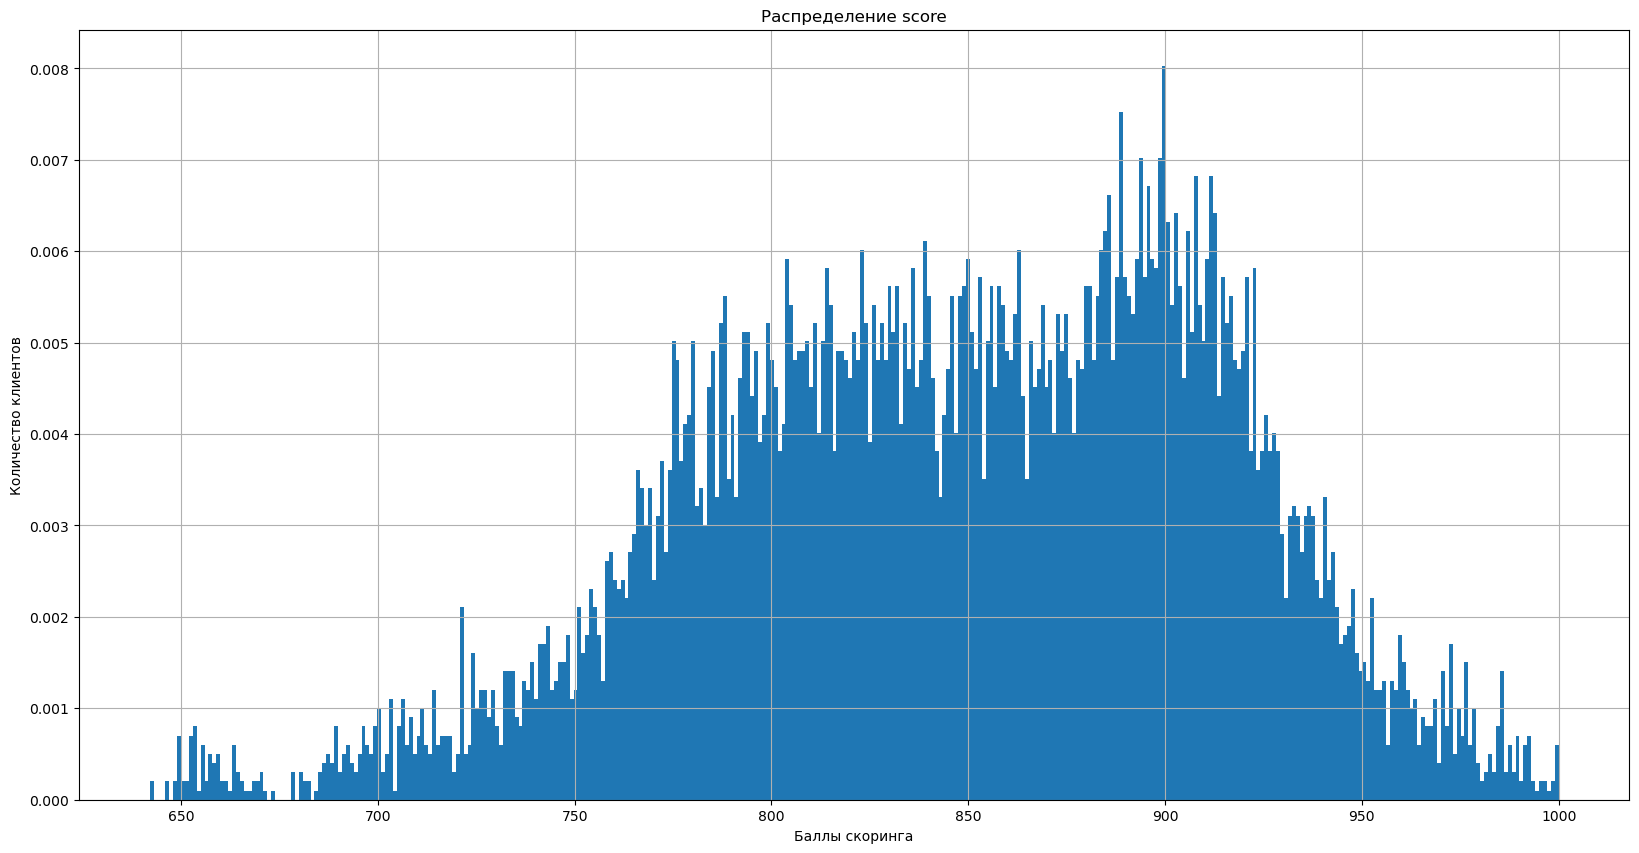

In [20]:
bc['score'].hist(bins=359, density=True)
plt.title("Распределение score")
plt.xlabel("Баллы скоринга")
plt.ylabel("Количество клиентов")
plt.show()

Значение скоринга распределено между значениями 642 и 1000. Явных аномалий не вижу, оставляем полный диапазон

**age**

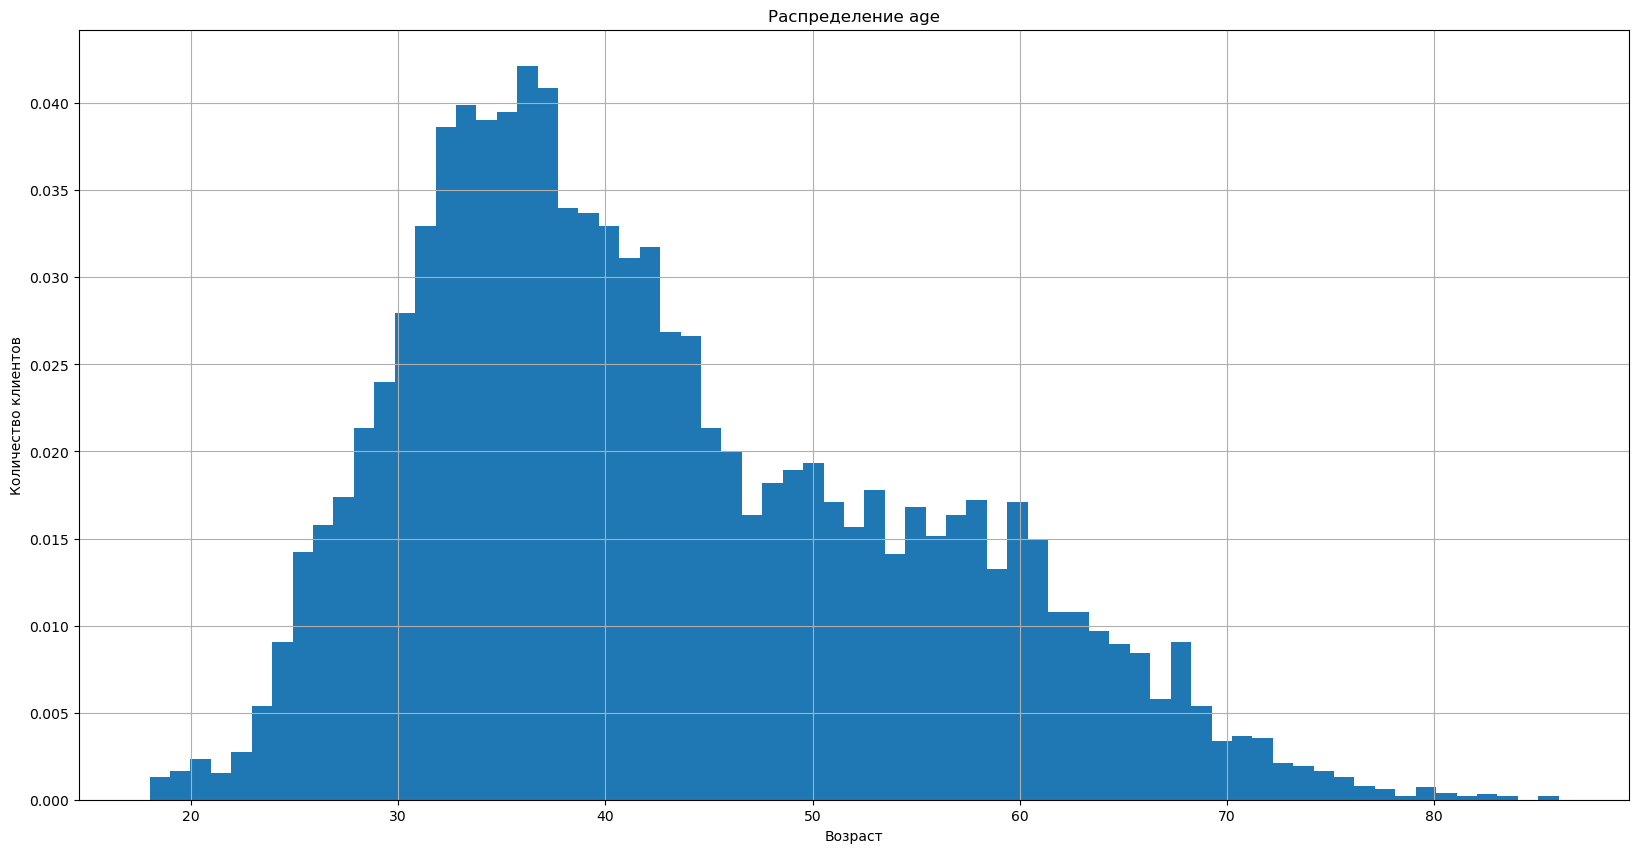

In [21]:
bc['age'].hist(bins=69, density=True)
plt.title("Распределение age")
plt.xlabel("Возраст")
plt.ylabel("Количество клиентов")
plt.show()

Значение возраста распределено между значениями 18 и 86. Выглядит реалистично, явных аномалий не вижу, нет смысла терять данные, оставляем полный диапазон

**equity**

In [22]:
equity_bar = bc.pivot_table(index='equity', values='user_id', aggfunc='count').reset_index()

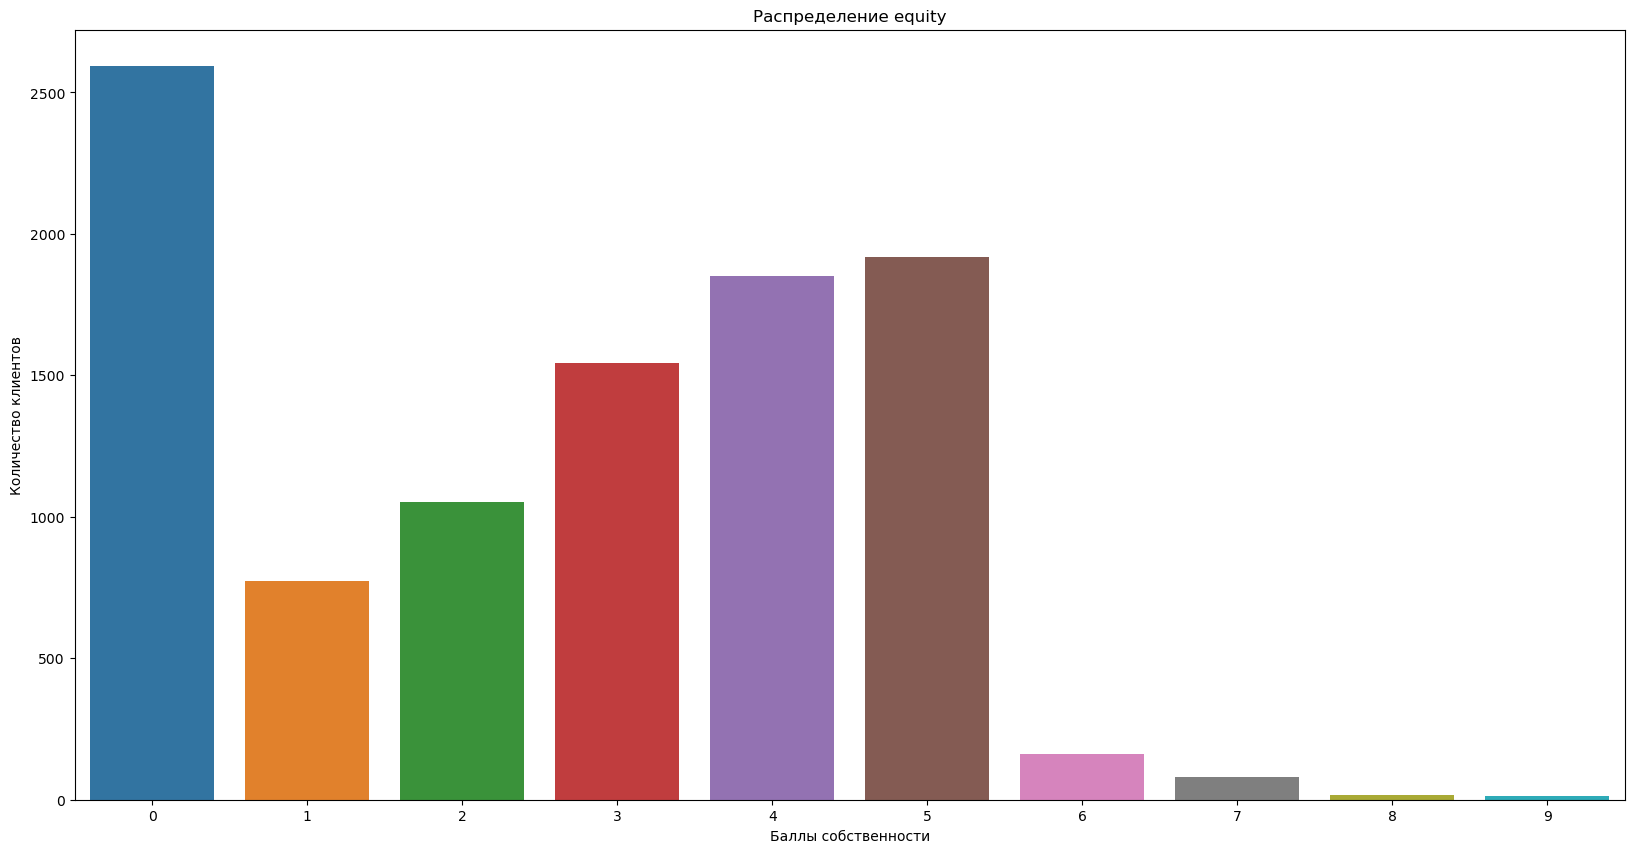

In [23]:
ax = sns.barplot(x='equity', y='user_id', data=equity_bar)
plt.title("Распределение equity")
plt.xlabel("Баллы собственности")
plt.ylabel("Количество клиентов")
plt.show()

Обращает внимание значительная доля клиентов без собственности, но это допустимо в рамках бизнес логики. Оставляем полный диапазон значений

**balance**

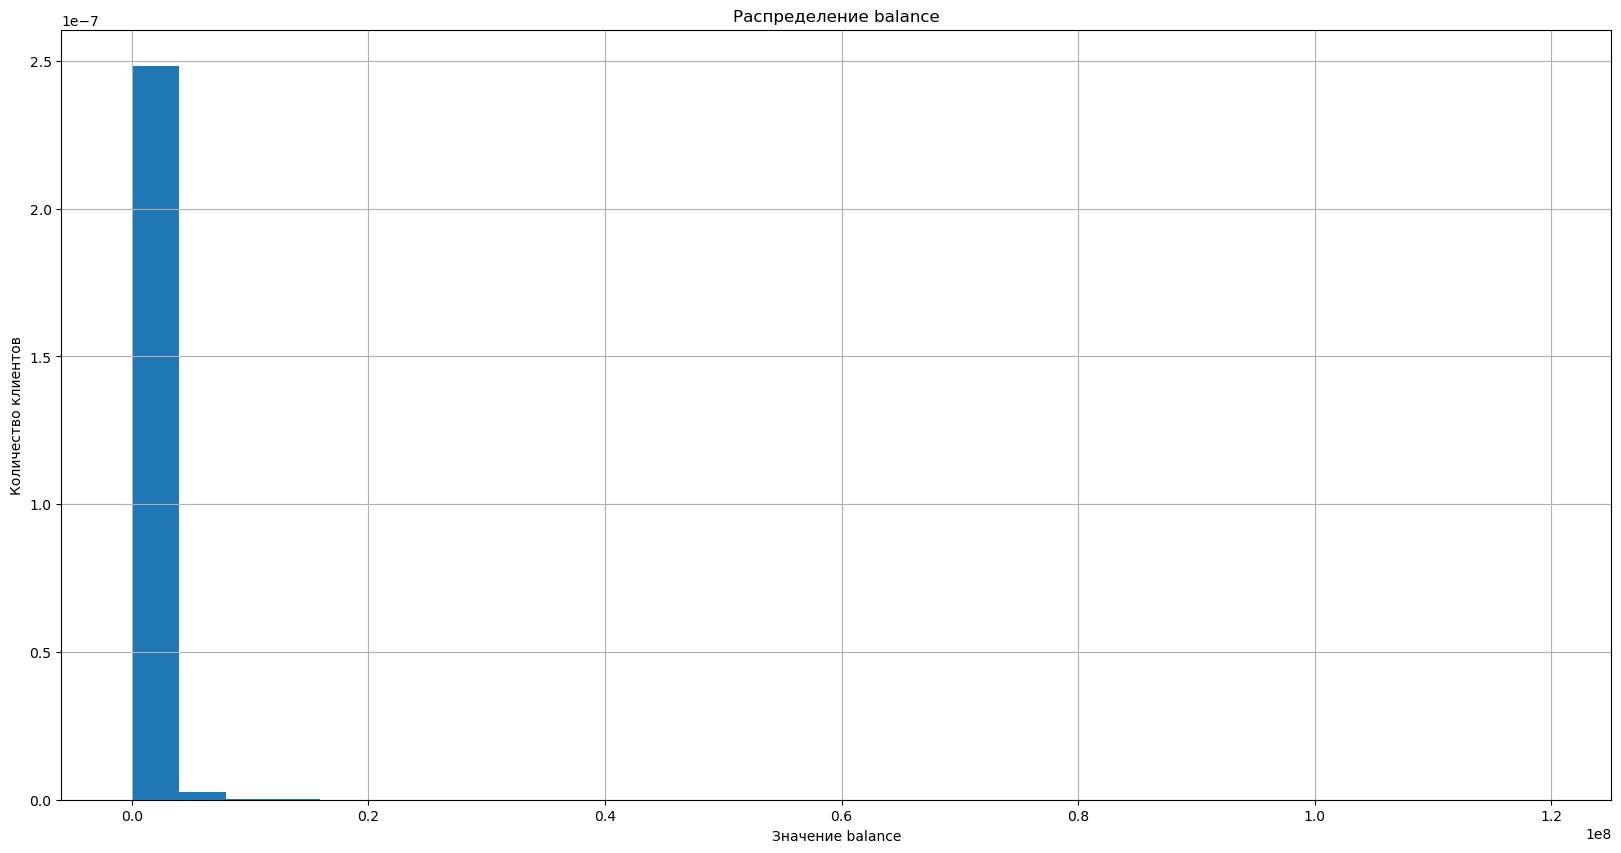

In [24]:
bc['balance'].hist(bins=30, density=True)
plt.title("Распределение balance")
plt.xlabel("Значение balance")
plt.ylabel("Количество клиентов")
plt.show()

Гистограмма получилась не наглядной, разделим все значения в столбце balance на 1 тысячу, для более наглядного отображения

In [25]:
bc['balance'] = (bc['balance']/1000).round(2)

По гистограме видно что большинство значений сосредоточено в диапазоне от 0 до 5000, при этом ее хвост за 100 000, середина в районе 500, не будем удалять из выборки клиентов с большим балансом, возможно позже они сформируют нужный нам сегмент, но гистограму отобразим нагляднее, сделав акцент на целевом диапазоне с 0 до 5000

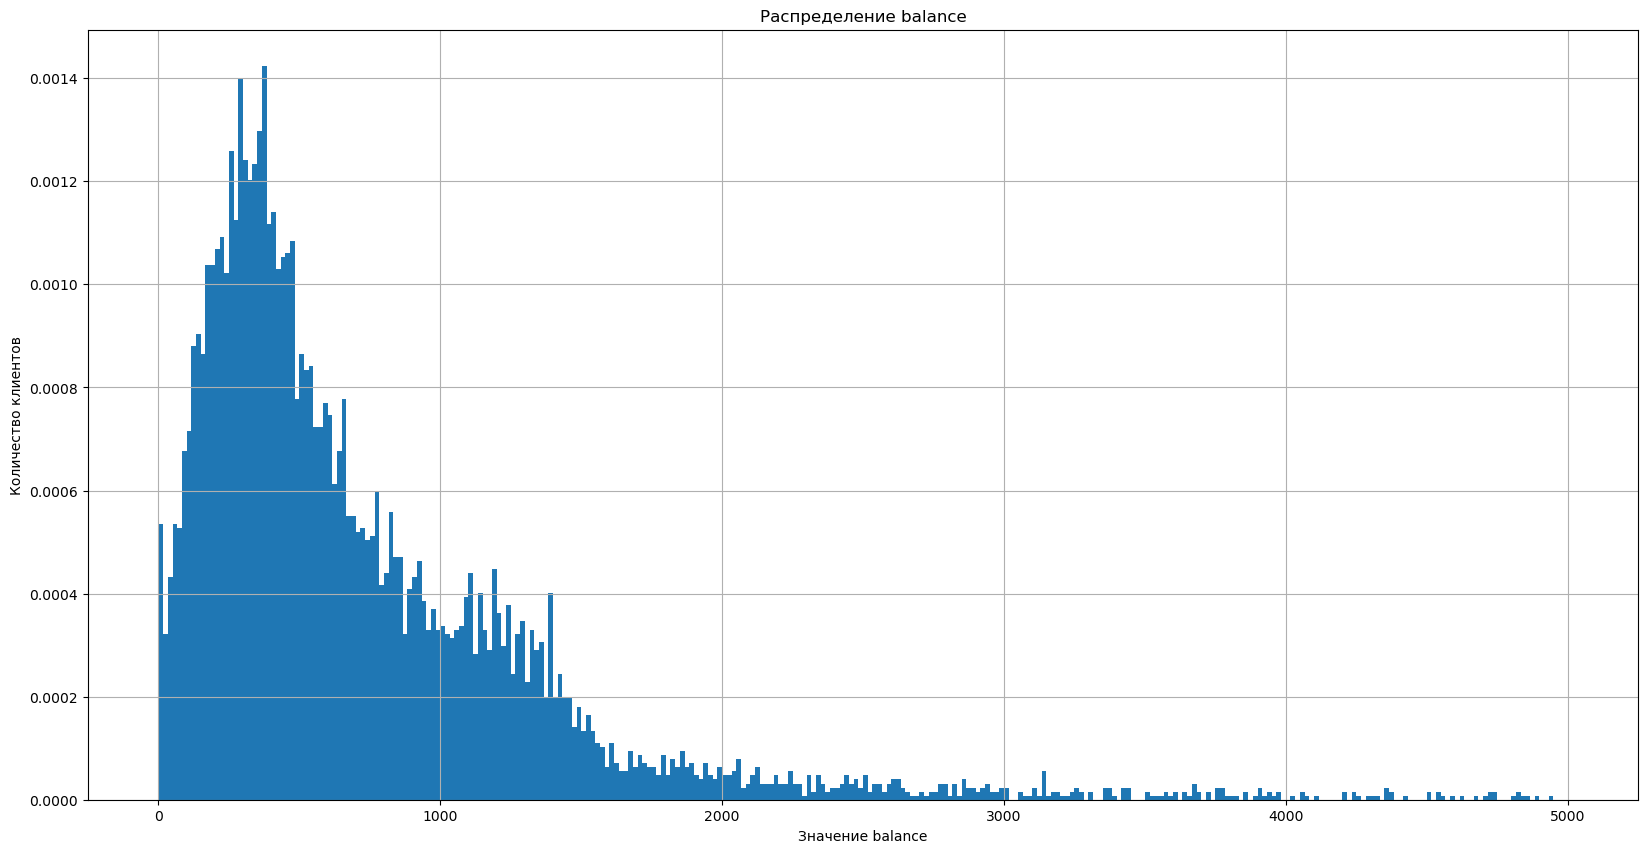

In [26]:
bc['balance'].hist(bins=300, density=True, range=(0,5000))
plt.title("Распределение balance")
plt.xlabel("Значение balance")
plt.ylabel("Количество клиентов")
plt.show()

**products**

In [27]:
products_bar = bc.pivot_table(index='products', values='user_id', aggfunc='count').reset_index()
products_bar = products_bar.query('products >= 1')

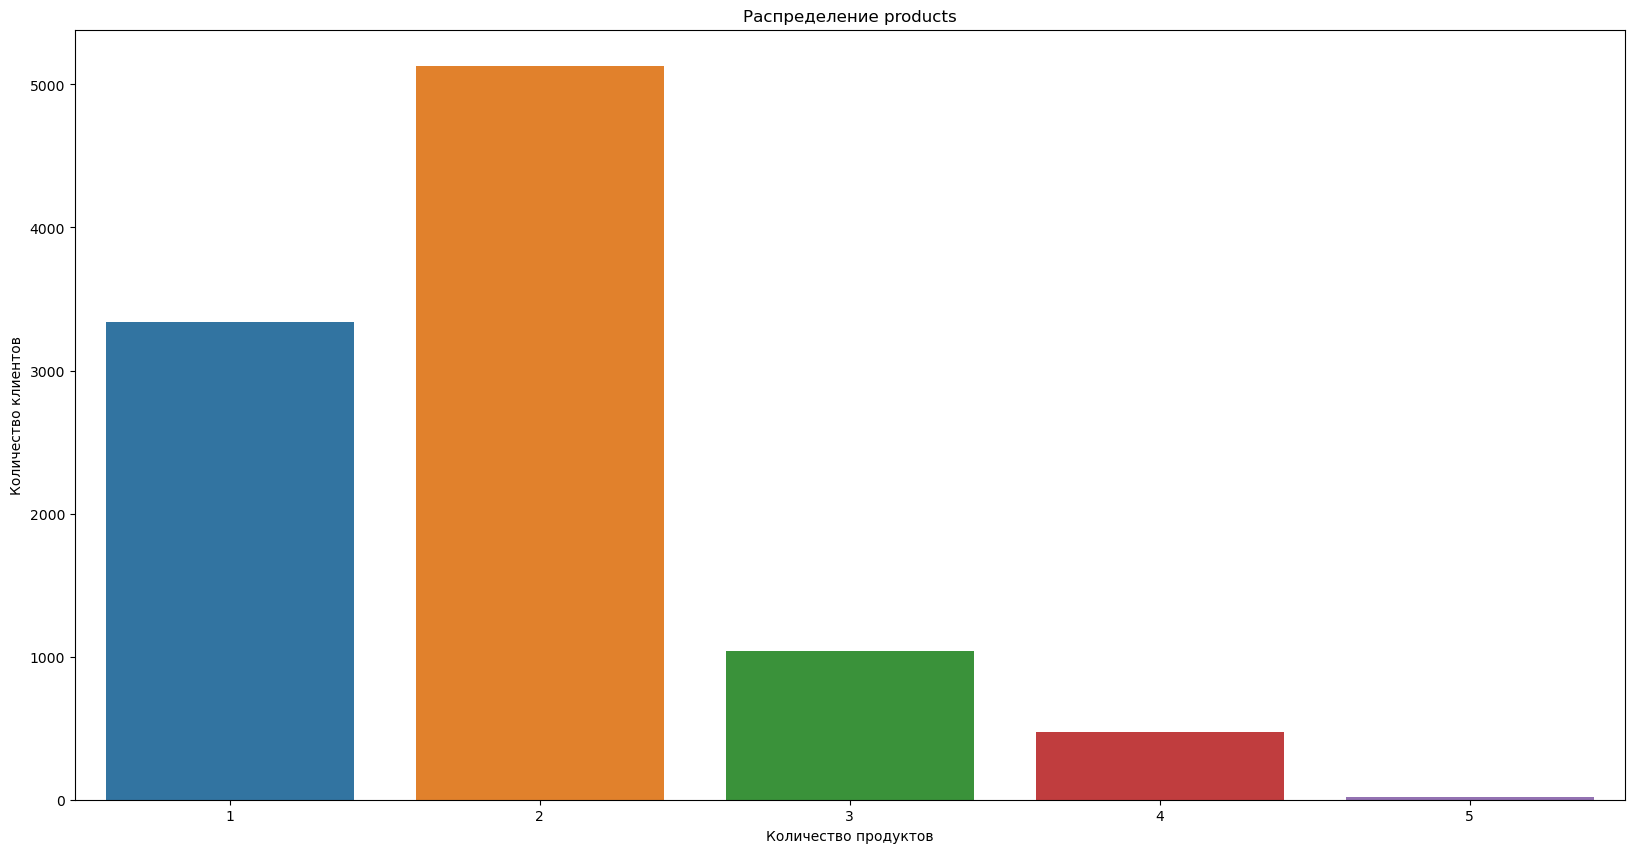

In [28]:
ax = sns.barplot(x='products', y='user_id', data=products_bar)
plt.title("Распределение products")
plt.xlabel("Количество продуктов")
plt.ylabel("Количество клиентов")
plt.show()

Значение количества продуктов распределено между значениями 0 и 5. Выглядит реалистично, явных аномалий не вижу, нет смысла терять данные, оставляем полный диапазон

**est_salary**

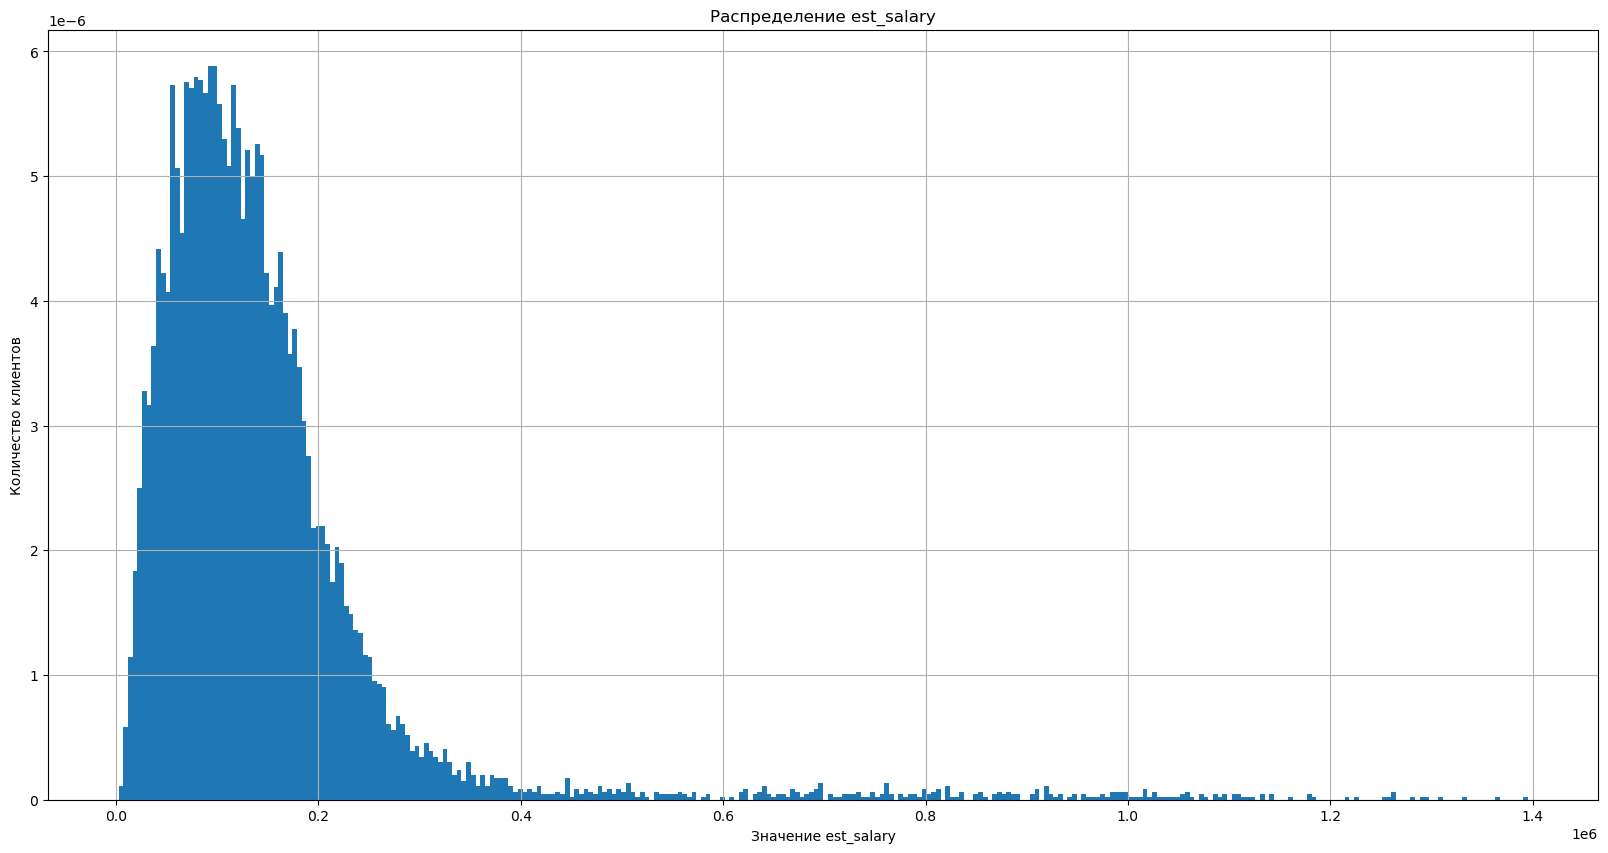

In [29]:
bc['est_salary'].hist(bins=300, density=True)
plt.title("Распределение est_salary")
plt.xlabel("Значение est_salary")
plt.ylabel("Количество клиентов")
plt.show()

Ситуация аналогична столбцу balance, разделим все значения в столбце balance на 1 тысячу, для более наглядного отображения. Есть клиенты с подтвержденным доходом сильно выше средненго, на гистограмме отражается хвост стремящийся к значению 1400, тогда как среднее в районе 120. Подход к обработке аналогичный, значения высоких ЗП оставляем в выборке, но сужаем диапазон с 0 до 400 на гистограмме

In [30]:
bc['est_salary'] = (bc['est_salary']/1000).round(2)

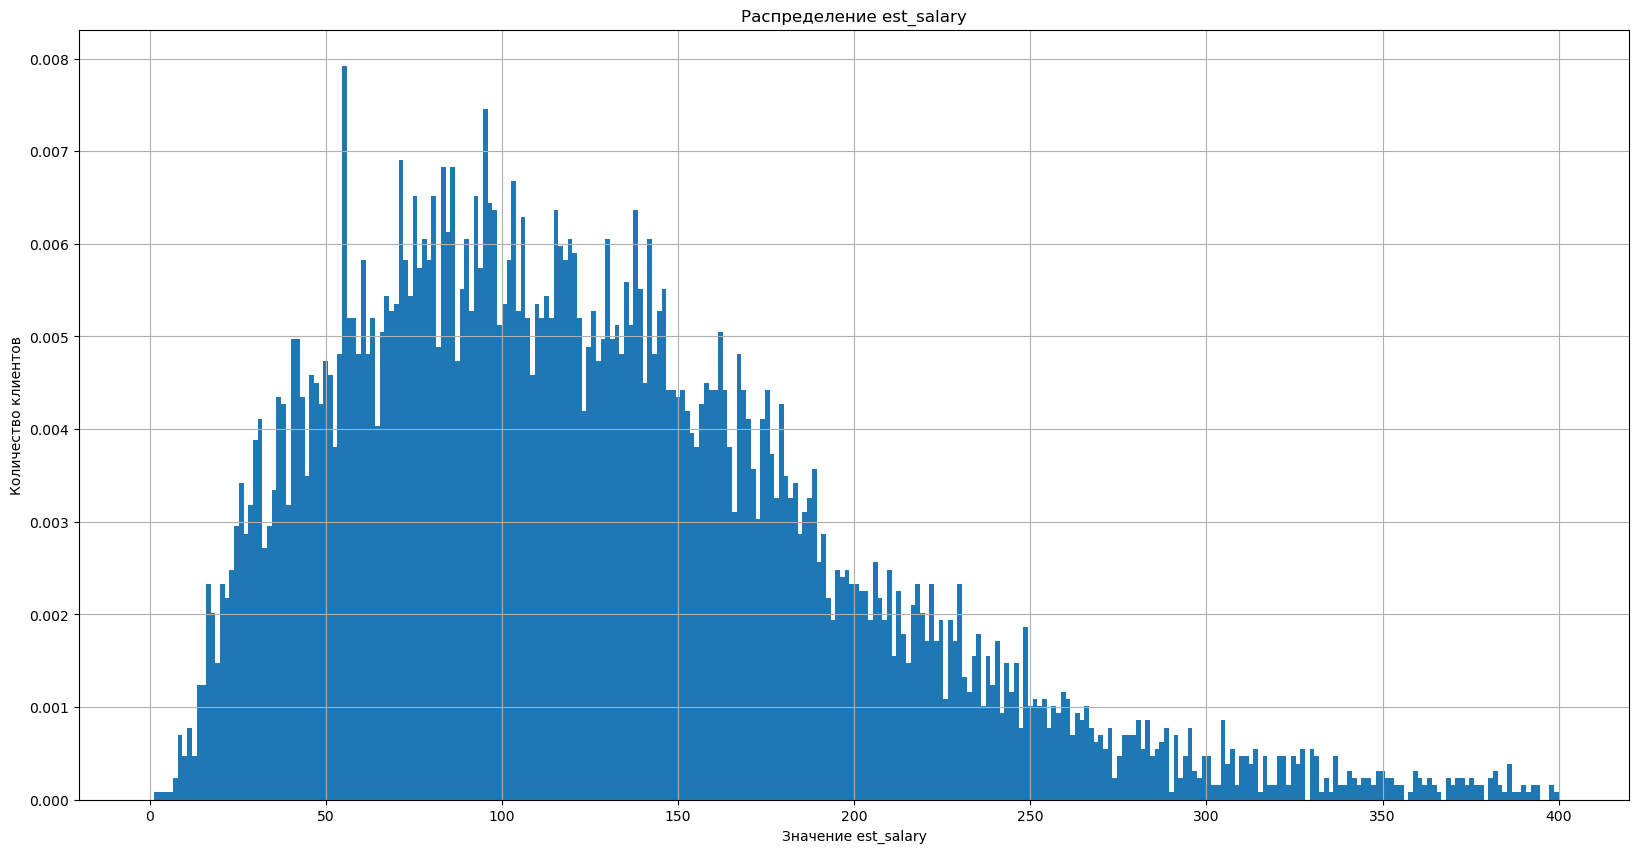

In [31]:
bc['est_salary'].hist(bins=300, density=True, range=(0,400))
plt.title("Распределение est_salary")
plt.xlabel("Значение est_salary")
plt.ylabel("Количество клиентов")
plt.show()

Далее рассмотрим столбцы с булевыми значениями, проверим что в них нет ошибочных значений

**credit_card**

In [32]:
bc['credit_card'].value_counts(normalize=True)*100

1    68.04
0    31.96
Name: credit_card, dtype: float64

**last_activity**

In [33]:
bc['last_activity'].value_counts(normalize=True)*100

1    52.35
0    47.65
Name: last_activity, dtype: float64

**churn**

In [34]:
bc['churn'].value_counts(normalize=True)*100

0    81.8
1    18.2
Name: churn, dtype: float64

С булевыми значениями все корректно, значения 0 или 1

#### Поиск особенностей в данных (для отточных клиентов и нет)

In [35]:
bc.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_pass,balance_pass
0,183012,850.0,Рыбинск,Ж,25.0,1,59.21,2,0,1,75.72,1,False,False
1,146556,861.0,Рыбинск,Ж,37.0,5,850.59,3,1,0,86.62,0,False,False
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107.68,0,False,True
3,225363,866.0,Ярославль,Ж,51.0,5,1524.75,2,0,1,174.42,1,False,False
4,157978,730.0,Ярославль,М,34.0,5,0.17,1,1,0,67.35,1,False,False


Подготовим сводную таблицу с расчетом моды для города и пола, в разрезе отточных и не отточных клиентов

In [36]:
churn_pivot = bc.pivot_table( columns='churn',
                                    values=('city','gender'),
                                    aggfunc=({'city':pd.Series.mode,
                                              'gender':pd.Series.mode}))
churn_pivot

churn,0,1
city,Ярославль,Ярославль
gender,Ж,М


Подготовим сводную таблицу с расчетом среднего для возраста и зарплаты, медианы для продуктов и количества собственности, в разрезе отточных и не отточных клиентов

In [37]:
churn_pivot_1 = bc.pivot_table( columns='churn',values=('age','est_salary','products','equity','score',
                                                        'balance','credit_card','last_activity'),
                               aggfunc=({'age': 'mean', 'est_salary':'mean','products': 'median',
                                         'equity':'median','score':'mean','balance':'mean',
                                         'credit_card':'mean','last_activity':'mean'}))
churn_pivot_1

churn,0,1
age,43.020846,41.450247
balance,733.982558,1133.993320
credit_card,0.709169,0.551099
equity,3.000000,4.000000
est_salary,147.783176,148.243000
last_activity,0.483741,0.702198
products,2.000000,2.000000
score,845.428362,863.401099


Переименую столбцы в таблицах

In [38]:
churn_pivot.columns = ['Значение признака для лояльного клиента','Значение признака для отточного клиента']
churn_pivot

,Значение признака для лояльного клиента,Значение признака для отточного клиента
city,Ярославль,Ярославль
gender,Ж,М


In [39]:
churn_pivot_1.columns = ['Значение признака для лояльного клиента','Значение признака для отточного клиента']
churn_pivot_1

,Значение признака для лояльного клиента,Значение признака для отточного клиента
age,43.020846,41.450247
balance,733.982558,1133.993320
credit_card,0.709169,0.551099
equity,3.000000,4.000000
est_salary,147.783176,148.243000
last_activity,0.483741,0.702198
products,2.000000,2.000000
score,845.428362,863.401099


Создадим в таблицах новый столбец ratio, с расчетом средней для непрерывных величин, и с заглушкой для категориальных

In [40]:
churn_pivot['Относительная разница'] = '-'
churn_pivot

,Значение признака для лояльного клиента,Значение признака для отточного клиента,Относительная разница
city,Ярославль,Ярославль,-
gender,Ж,М,-


In [41]:
churn_pivot_1['Относительная разница'] = (churn_pivot_1['Значение признака для лояльного клиента']/
                                          churn_pivot_1['Значение признака для отточного клиента']*100).round(2)
churn_pivot_1

,Значение признака для лояльного клиента,Значение признака для отточного клиента,Относительная разница
age,43.020846,41.450247,103.79
balance,733.982558,1133.993320,64.73
credit_card,0.709169,0.551099,128.68
equity,3.000000,4.000000,75.00
est_salary,147.783176,148.243000,99.69
last_activity,0.483741,0.702198,68.89
products,2.000000,2.000000,100.00
score,845.428362,863.401099,97.92


Обьединим две таблицы в одну

In [42]:
churn_union_all= pd.concat([churn_pivot, churn_pivot_1])
churn_union_all

,Значение признака для лояльного клиента,Значение признака для отточного клиента,Относительная разница
city,Ярославль,Ярославль,-
gender,Ж,М,-
age,43.020846,41.450247,103.79
balance,733.982558,1133.99332,64.73
credit_card,0.709169,0.551099,128.68
equity,3.0,4.0,75.0
est_salary,147.783176,148.243,99.69
last_activity,0.483741,0.702198,68.89
products,2.0,2.0,100.0
score,845.428362,863.401099,97.92


также создадим 2 базовые таблицы для дальнейшего исследования. В одной будут клиенты которые ушли из банка (churn=1) и клиенты которые еще являются клиентами (churn=0)

In [43]:
bc_churn_y = bc.query('churn==1')
bc_churn_y['user_id'].count()

1820

In [44]:
bc_churn_n = bc.query('churn==0')
bc_churn_n['user_id'].count()

8180

Для наглядности отобразим пропорцию отточных клиентов на круговой диаграмме

In [45]:
churn_pivot = bc.pivot_table(index='churn', values='user_id'
                             , aggfunc='count').reset_index().rename(columns={'user_id':'count'})
churn_pivot

,churn,count
0,0,8180
1,1,1820


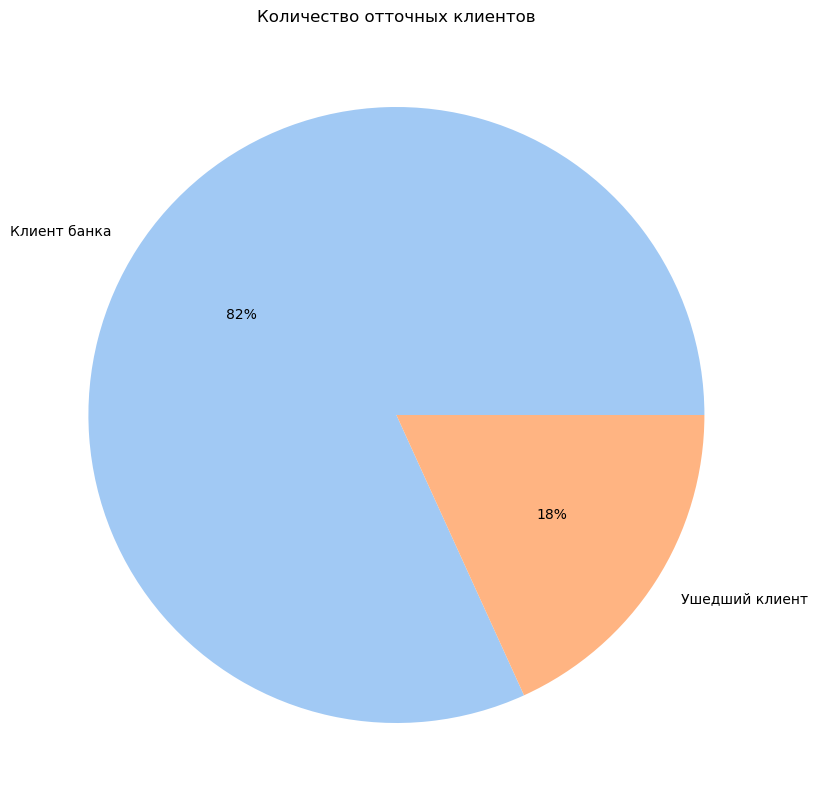

In [46]:
colors = sns.color_palette('pastel')[ 0:5 ]
labels = ['Клиент банка', 'Ушедший клиент']
plt.title("Количество отточных клиентов")
plt.pie(churn_pivot['count'],labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

Итого, в выборке из 10 тысяч клиентов, 1820 являются отточными, что составляет 18% от общего числа. **Запомним это значение, оно является средней отточностью по банку.** Поместили отточных клиентов в отдельную таблицу bc_churn_y, далее рассмотрим выделяющиеся признаки характерные для этой группы и зафиксируем их значения

**score**

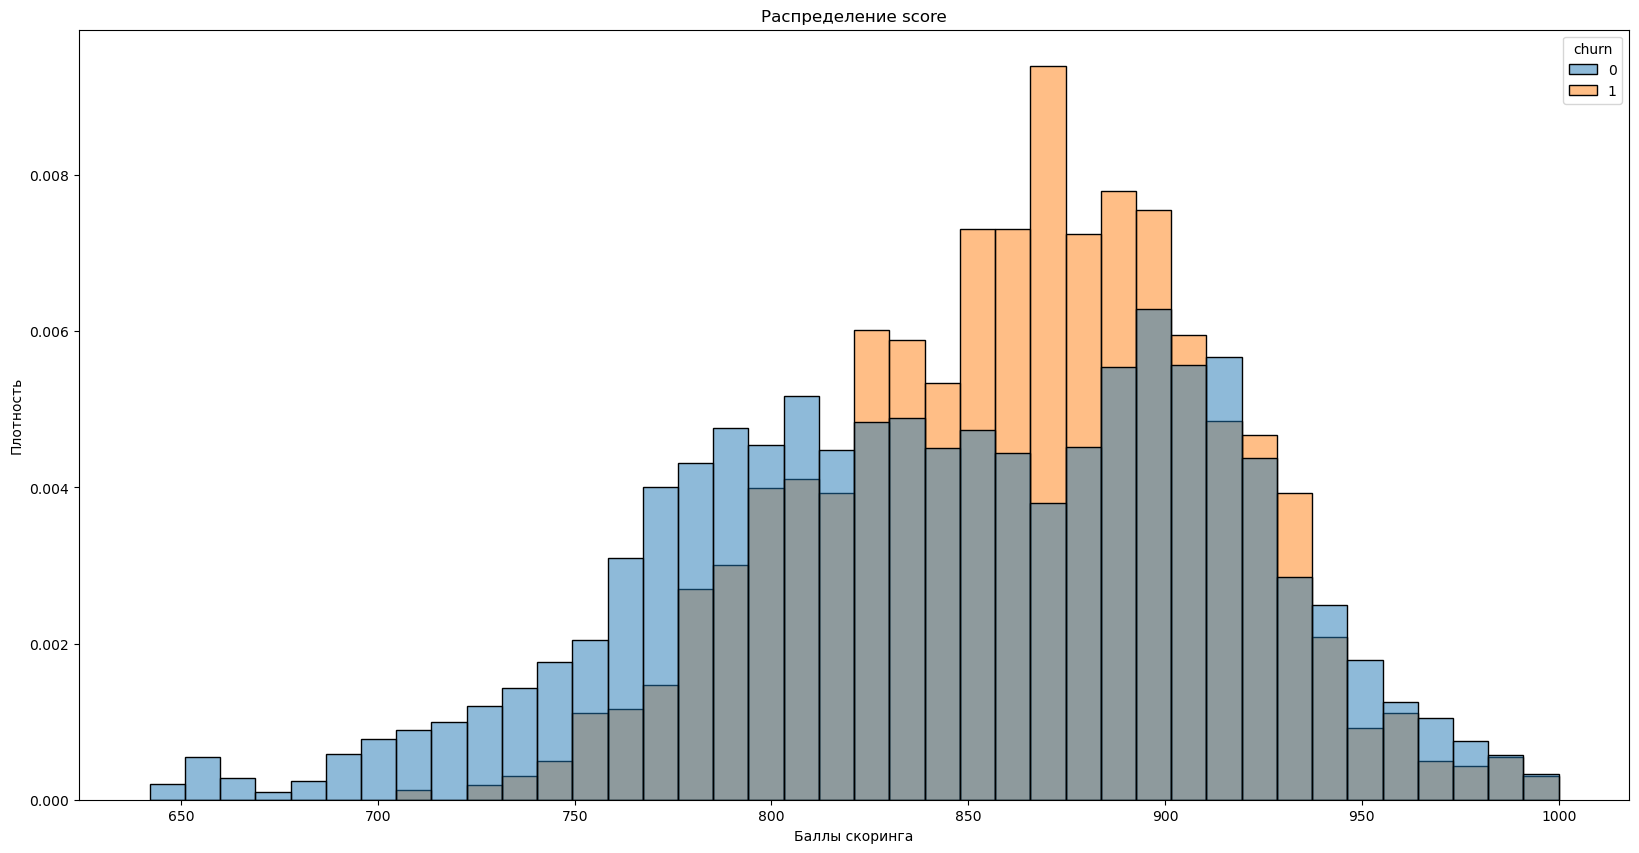

In [47]:
sns.histplot(
    bc, x="score", hue="churn",
    stat="density", common_norm=False
)
plt.title("Распределение score")
plt.xlabel("Баллы скоринга")
plt.ylabel("Плотность")
plt.show()

Анализируя гистограммы и значение агрегирующих характеристик, можно сделать вывод, что для отточных клиентов средний скоринг составляет 866 балов, шкала  имеет нормальное распределение. Можно обратить внимание, что колличество ушедших клиентов имеет сравнительно большие показатели в промежутке с 830 по 900 балл скоринга. Подведем итог, характерные значения скоринга для двух выборок имеют схожие средние характеристики и распределение, доля клиентов банка выше чем у отточных на нихких баллах скоринга, на высоких картина обратная

**city**

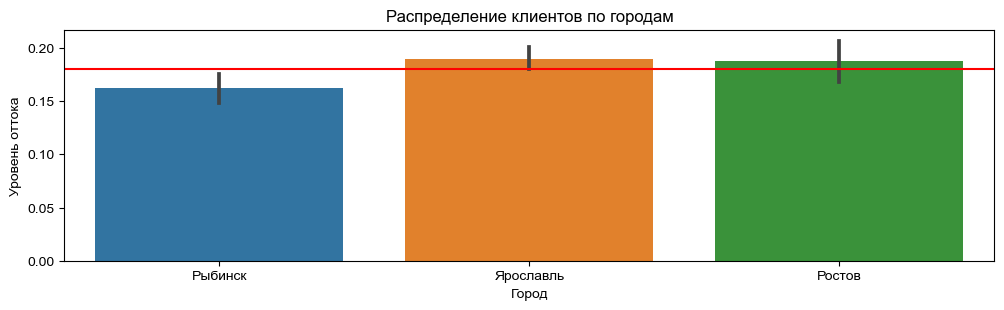

In [48]:
plt.figure(figsize=(12, 3))
sns.barplot(x='city', y='churn', data=bc)
plt.title("Распределение клиентов по городам")
sns.set_style('dark')
sns.set_palette('pastel') 
plt.xlabel("Город")
plt.ylabel("Уровень оттока")
plt.axhline(y=0.18,color='r')
plt.show()

Уровень оттока в городе Ярославль и Ростов немного превышает средний уровень оттока по банку, тогда как в городе Рыбинск доля ушедших клиентов ниже

**gender**

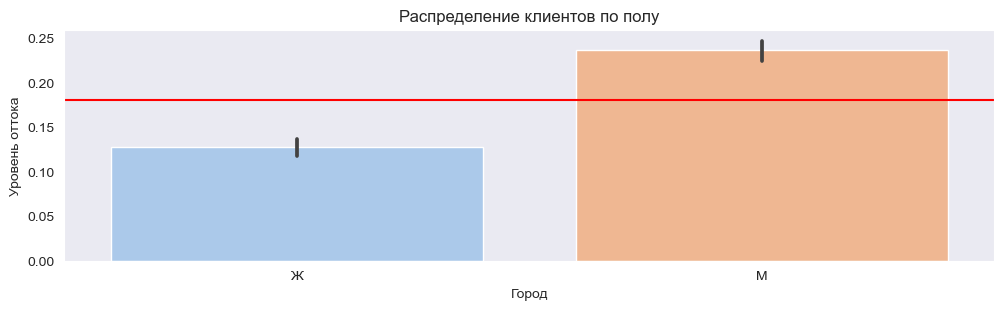

In [49]:
plt.figure(figsize=(12, 3))
sns.barplot(x='gender', y='churn', data=bc)
plt.title("Распределение клиентов по полу")
sns.set_style('dark')
sns.set_palette('pastel') 
plt.xlabel("Город")
plt.ylabel("Уровень оттока")
plt.axhline(y=0.18,color='r')
plt.show()

Отточнось среди мужчин выше чем у женщин и превышает среднюю отточность по банку

**age**

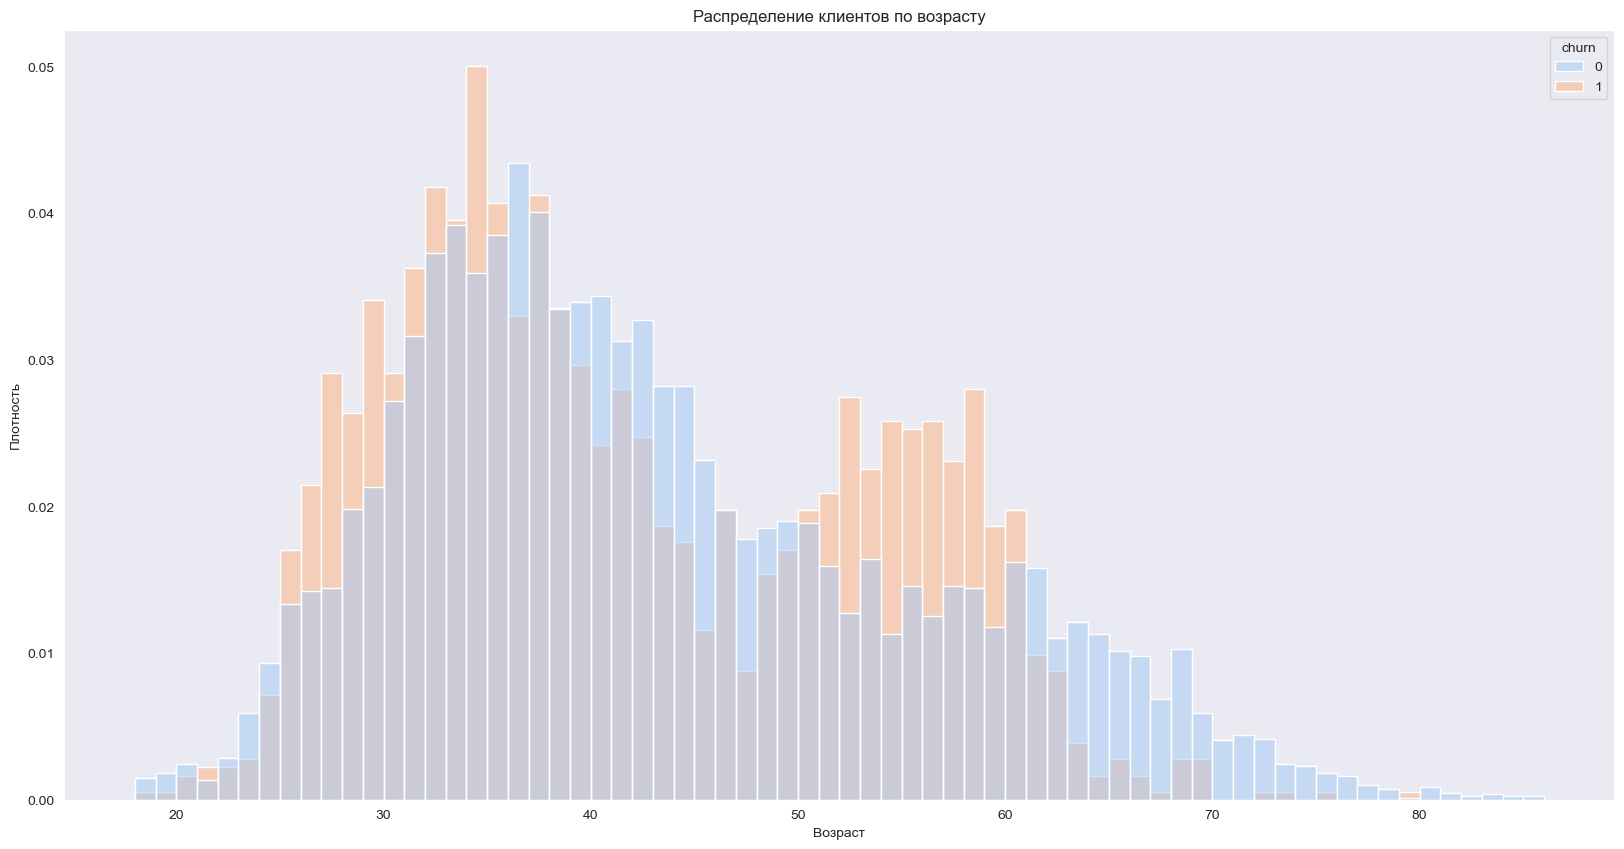

In [50]:
sns.histplot(
    bc, x="age", hue="churn",
    stat="density", common_norm=False, binwidth=1
)
plt.title("Распределение клиентов по возрасту")
plt.xlabel("Возраст")
plt.ylabel("Плотность")
plt.show()

При относительно схожем распределении, можно заметить что среди клиентов, имеющих возраст с 25 до 30 и с 50 до 60, вероятность ухода из банка выше

**equity**

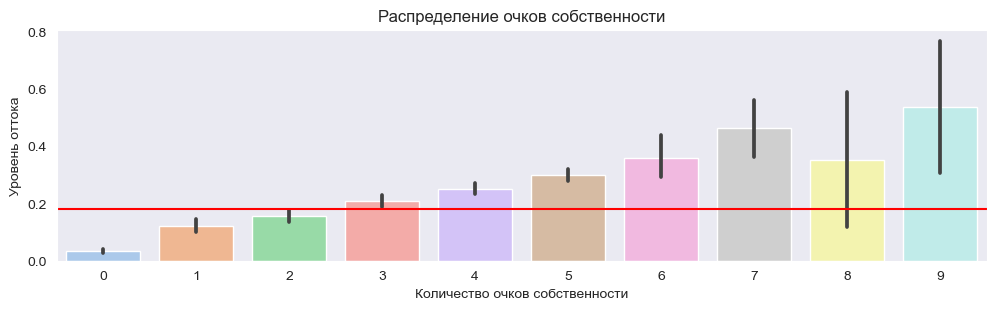

In [51]:
plt.figure(figsize=(12, 3))
sns.barplot(x='equity', y='churn', data=bc)
plt.title("Распределение очков собственности")
sns.set_style('dark')
sns.set_palette('pastel') 
plt.xlabel("Количество очков собственности")
plt.ylabel("Уровень оттока")
plt.axhline(y=0.18,color='r')
plt.show()

Средняя по отточным клиентам на 58% выше средней по клиентам банка. Большую склонность к оттоку имеют клиенты  с 3 и более очков собственности

**balance**

Ранее в ходе поиска аномальных значений, для нормализации данных по балансу нами был определен промежуток значений с 0 по 5000, построим диаграмму, и посмотрим на количество клиентов слонных к оттоку в этом промежутке

In [52]:
bc_balance_5000 = bc.query('balance <= 5000')

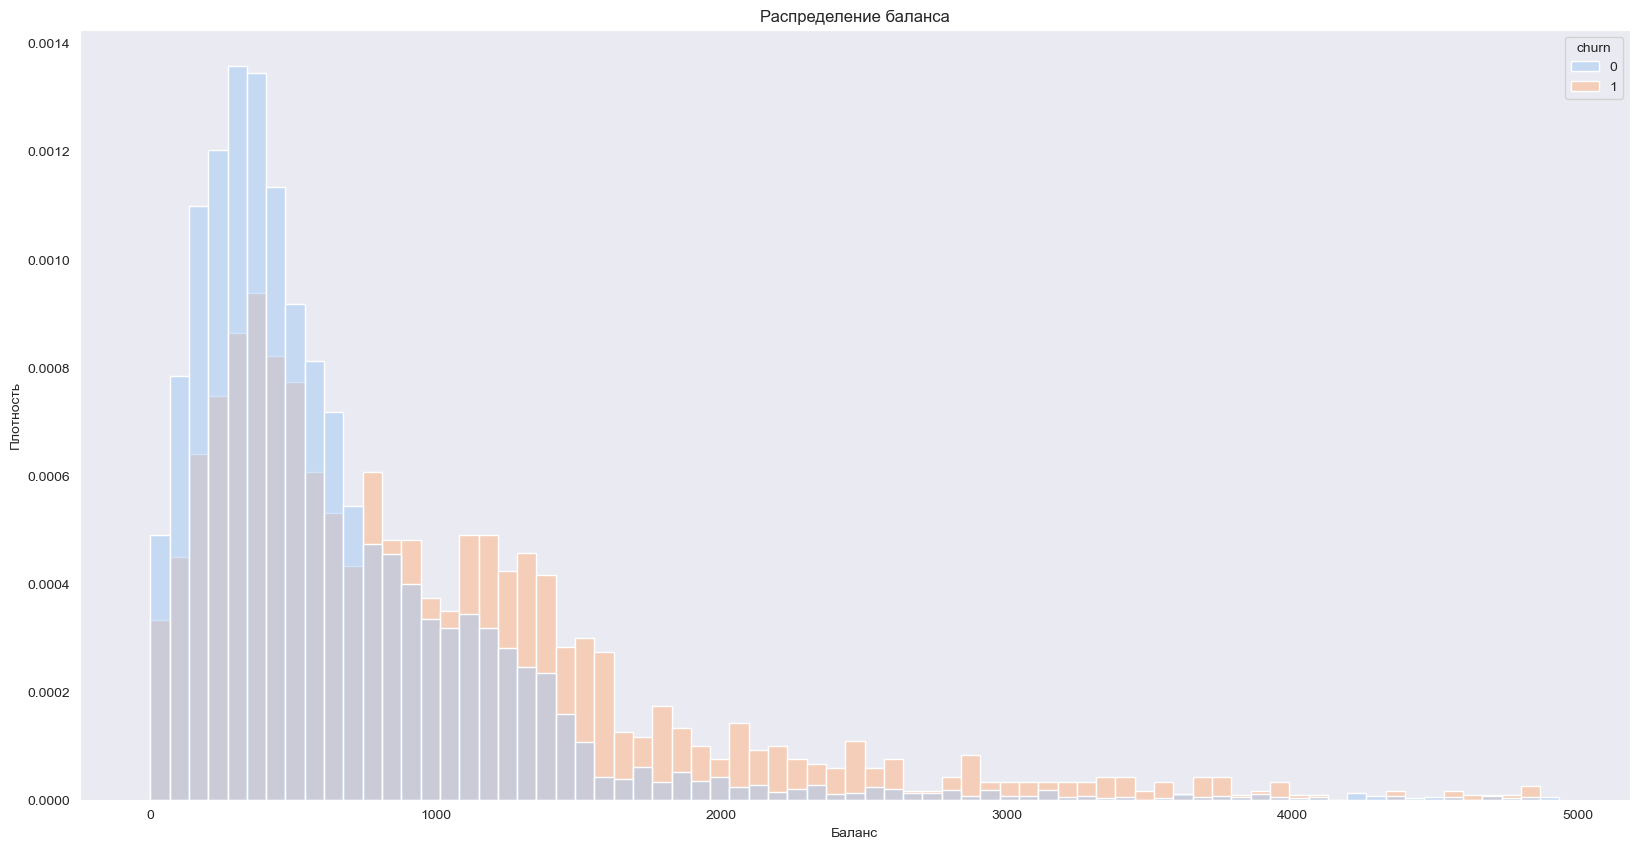

In [53]:
sns.histplot(
    bc_balance_5000, x="balance", hue="churn",
    stat="density", common_norm=False
)
plt.title("Распределение баланса")
plt.xlabel("Баланс")
plt.ylabel("Плотность")
plt.show()

Большую склонность к оттоку имеют клиенты с балансом выше среднего, от 1000 и выше

**products**

In [54]:
bc = bc.query('products >=1')

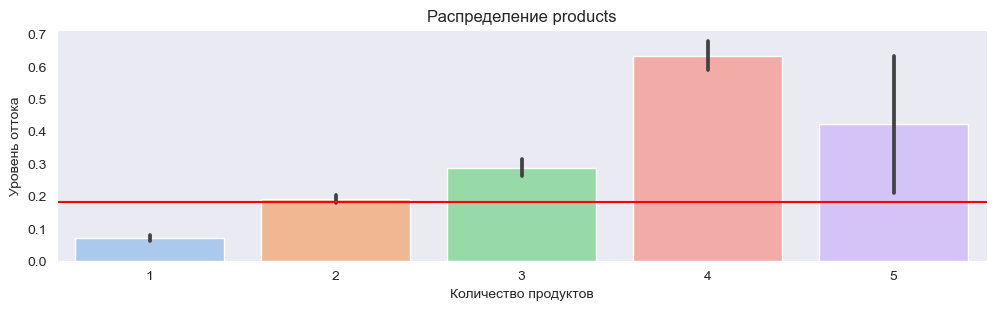

In [55]:
plt.figure(figsize=(12, 3))
sns.barplot(x='products', y='churn', data=bc)
plt.title("Распределение products")
sns.set_style('dark')
sns.set_palette('pastel') 
plt.xlabel("Количество продуктов")
plt.ylabel("Уровень оттока")
plt.axhline(y=0.18,color='r')
plt.show()

Клиенты более склонные к оттоку имеют 3 и более продуктов, реже 2

**credit_card**

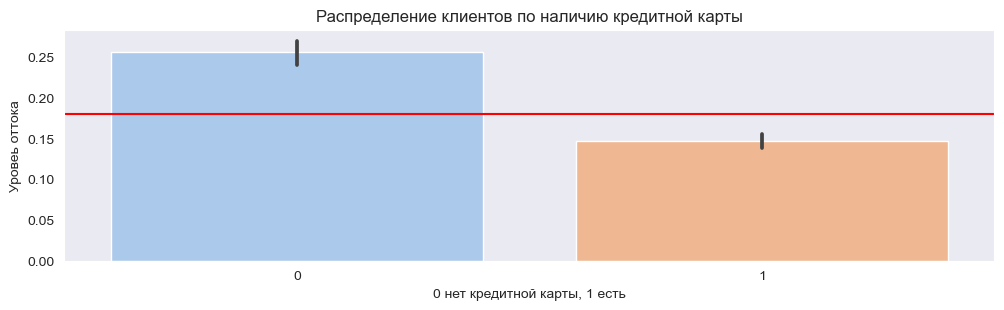

In [56]:
plt.figure(figsize=(12, 3))
sns.barplot(x='credit_card', y='churn', data=bc)
plt.title("Распределение клиентов по наличию кредитной карты")
sns.set_style('dark')
sns.set_palette('pastel') 
plt.xlabel("0 нет кредитной карты, 1 есть")
plt.ylabel("Уровеь оттока")
plt.axhline(y=0.18,color='r')
plt.show()

Среди клиентов держателей кредитной карты, отточность ниже, по сравнению с теми у кого кредитной карты нет

**last_activity**

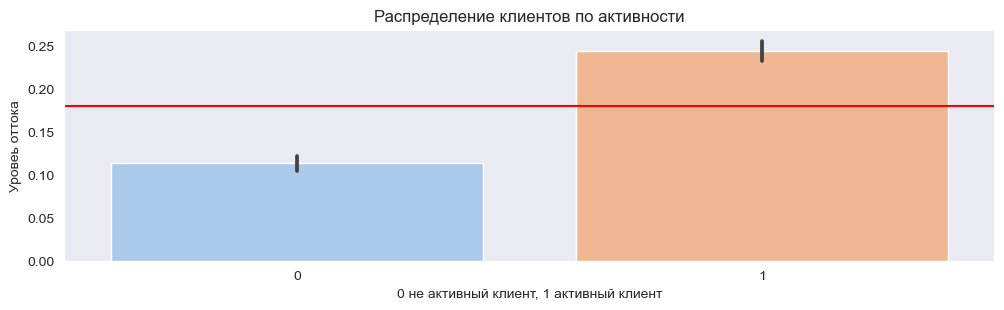

In [57]:
plt.figure(figsize=(12, 3))
sns.barplot(x='last_activity', y='churn', data=bc)
plt.title("Распределение клиентов по активности")
sns.set_style('dark')
sns.set_palette('pastel') 
plt.xlabel("0 не активный клиент, 1 активный клиент")
plt.ylabel("Уровеь оттока")
plt.axhline(y=0.18,color='r')
plt.show()

Интересное наблюдение, среди отточных клиентов больший процент являлись активными клиентами банка. Отток для активных клиентов превосходит среднее значение по банку

**est_salary**

Ранее в ходе поиска аномальных значений, для нормализации данных по уровню заработной платы нами был определен промежуток значений с 0 по 400, построим диаграмму, и посмотрим на количество клиентов слонных к оттоку в этом промежутке

In [58]:
bc_estsalary_400 = bc.query('est_salary <= 400')

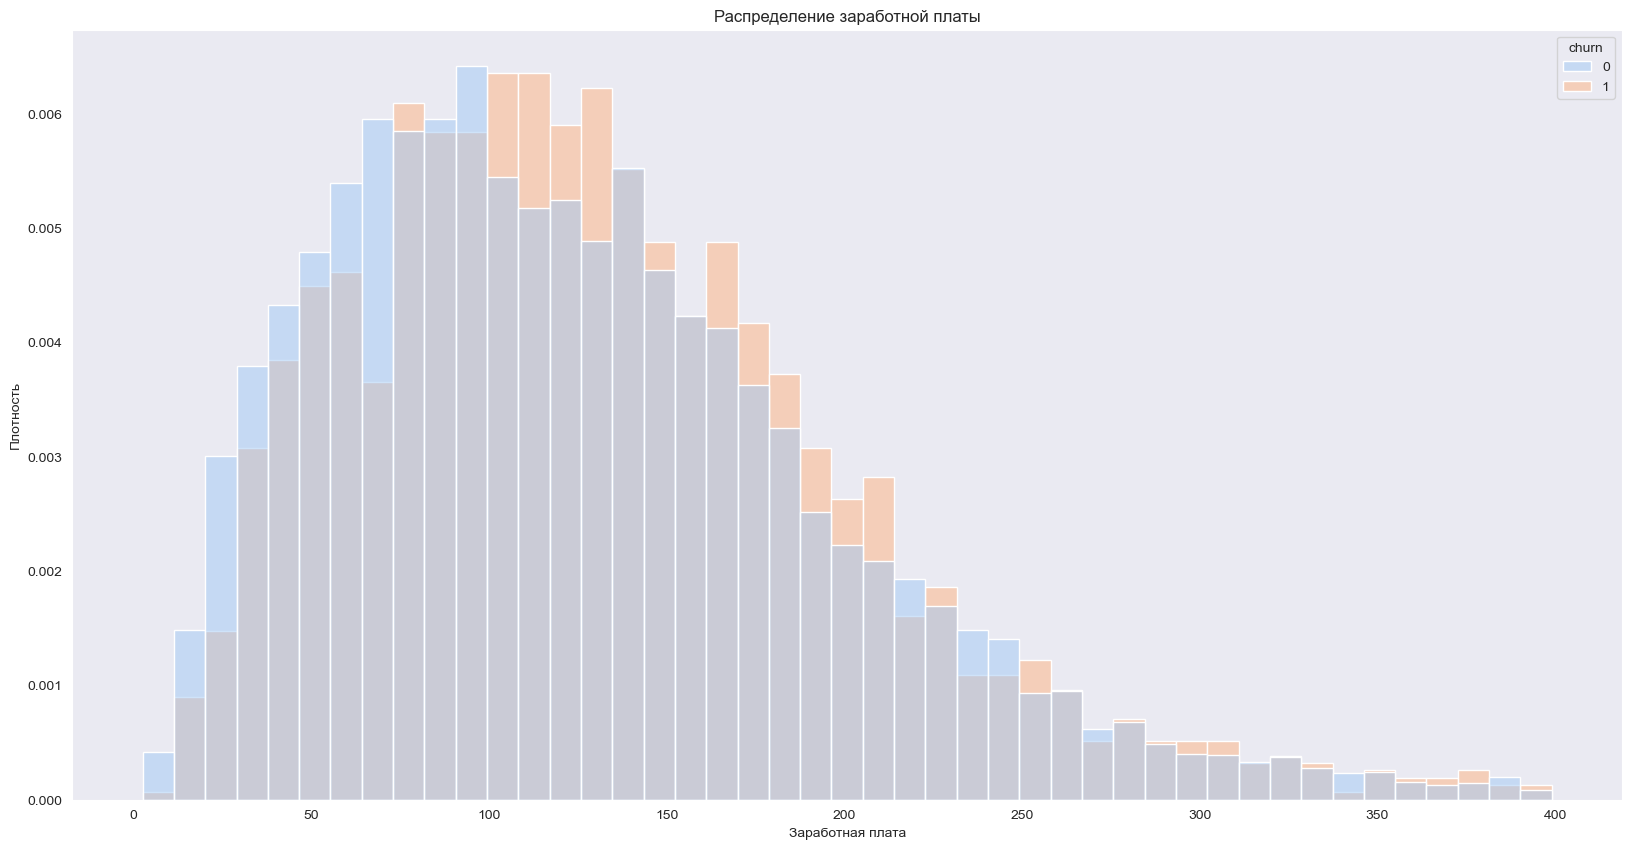

In [59]:
sns.histplot(
    bc_estsalary_400, x="est_salary", hue="churn",
    stat="density", common_norm=False
)
plt.title("Распределение заработной платы")
plt.xlabel("Заработная плата")
plt.ylabel("Плотность")
plt.show()

И опять же, распределение для двух выборок имеет схожий вид, можно отметить практически одинаковую среднюю (147, против 148). Отточность среди клиентов с ЗП от 100 до 200 выше, по сравнению с аналогичным уровнем ЗП для не отточных клиентов

Основываясь на проведенном анализе, составим портрет типичного отточного клиента, выбрав признаки более характеризующие отток и зафиксируем наблюдения:

- city - Уровень оттока в городе Ярославль и Ростов немного превышает средний уровень оттока по банку, тогда как в городе Рыбинск доля ушедших клиентов ниже.
- gender - типичный отказник, это мужчина.
- age - в возрасте 50-60 лет доля отточных клиентов растет.
- score - в диапазоне 830-900 наблюдается небольшая тенденция к росту у отточных клиентов, против снижения  лояльных.
- equity - Большую склонность к оттоку имеют клиенты  с 3 и более очков собственности.
- balance - замечено, что отточные клиенты имеют выше баланс на счету, показатели значений от 1000 и выше
- products - как ранее отмечено, клиенты с продуктами больше 3 более склонны к оттоку, аналогичная тенденция наблюдается для владельцев двух продуктов, но разница менее выражена
- last_activity - Интересное наблюдение, среди отточных клиентов больший процент являлись активными клиентами банка. Отток для активных клиентов превосходит среднее значение по банку
- est_salary - Отточность среди клиентов с ЗП от 100 до 200 выше, по сравнению с аналогичным уровнем ЗП для не отточных клиентов

#### Интервалы признаков с повышенным оттоком

Основываясь на проведенном анализе в предыдущих двух пунктах, определим интервалы, выбрав для непрерывных признаков диапазоны в которых отток выше чем лояльность, а также категорииальные признаки склонные к оттоку:

- Значение city: **Ярославль, Ростов**
- Значение gender: **Мужчина**
- Интервал age: **50-60**
- Интервал score: **830-900**
- Интервал equity: **>=3**
- Интервал balance: **1000-4000**
- Интервал products: **>=3**
- Значение last_activity: **1 Активный**
- Интервал est_salary: **100-200**

#### Поиск зависимостей (признак оттока от других признаков)

Рассмотрим зависимов всех признаков от признака оттока, в качестве данных будем использовать исходную таблицу

In [60]:
bc_n_user_id = bc
bc_n_user_id.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_pass,balance_pass
0,183012,850.0,Рыбинск,Ж,25.0,1,59.21,2,0,1,75.72,1,False,False
1,146556,861.0,Рыбинск,Ж,37.0,5,850.59,3,1,0,86.62,0,False,False
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107.68,0,False,True
3,225363,866.0,Ярославль,Ж,51.0,5,1524.75,2,0,1,174.42,1,False,False
4,157978,730.0,Ярославль,М,34.0,5,0.17,1,1,0,67.35,1,False,False


In [61]:
bc_n_user_id.pop('user_id')

0       183012
1       146556
2       120722
3       225363
4       157978
         ...  
9995    120553
9996    139170
9997    115639
9998    148700
9999     96267
Name: user_id, Length: 9999, dtype: int64

In [62]:
bc_n_user_id.head()

,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_pass,balance_pass
0,850.0,Рыбинск,Ж,25.0,1,59.21,2,0,1,75.72,1,False,False
1,861.0,Рыбинск,Ж,37.0,5,850.59,3,1,0,86.62,0,False,False
2,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107.68,0,False,True
3,866.0,Ярославль,Ж,51.0,5,1524.75,2,0,1,174.42,1,False,False
4,730.0,Ярославль,М,34.0,5,0.17,1,1,0,67.35,1,False,False


In [63]:
dependence = bc_n_user_id.phik_matrix(interval_cols=['score','balance','est_salary','age','user_id'])
dependence=dependence.sort_values(by='churn', ascending=False)
dependence['churn']

churn            1.000000
balance_pass     0.381830
equity           0.352737
last_activity    0.261583
products         0.260106
score            0.228260
gender           0.219184
credit_card      0.202586
age              0.183435
est_salary       0.047792
balance          0.024701
age_pass         0.020500
city             0.017054
Name: churn, dtype: float64

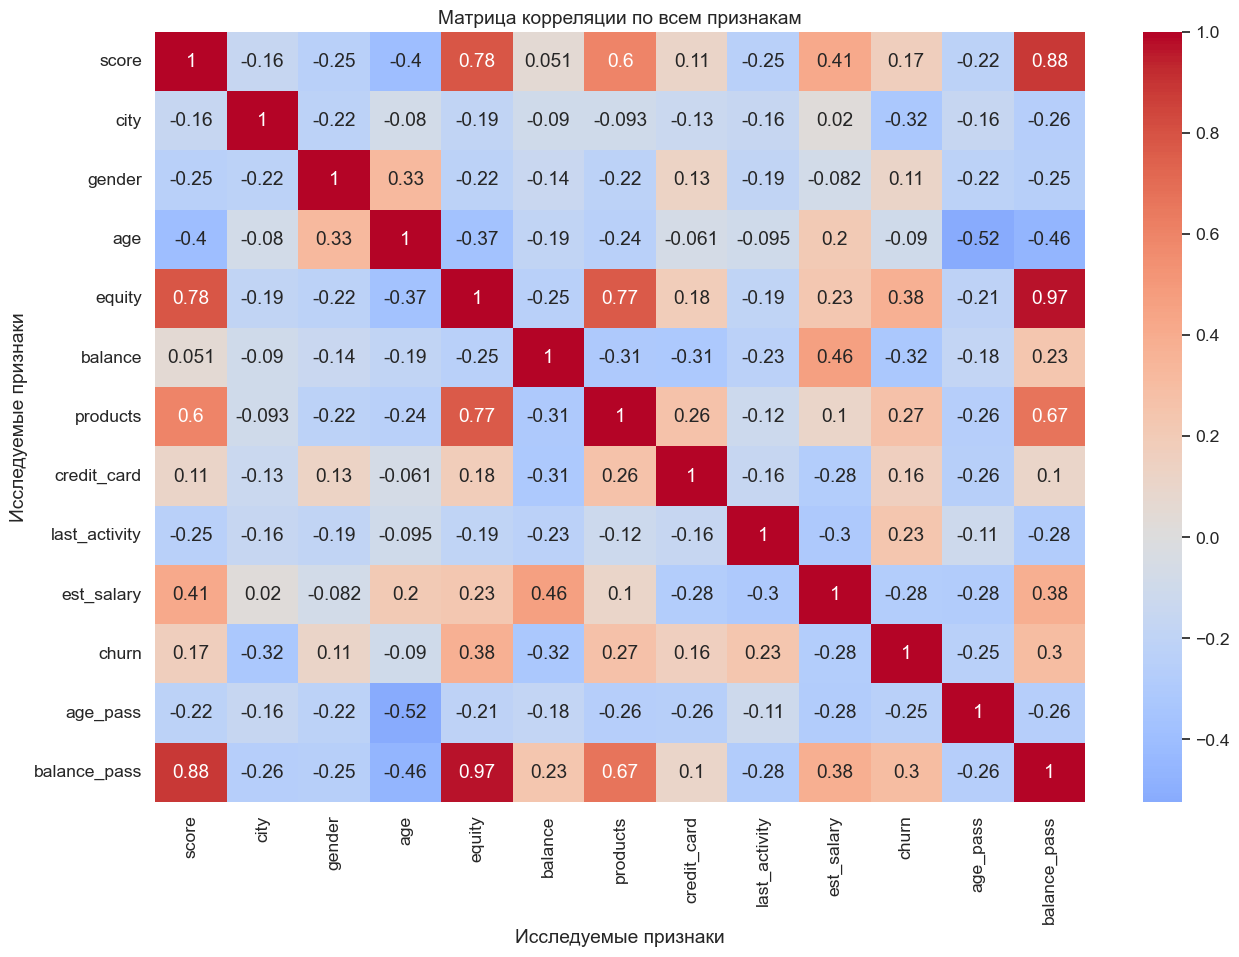

In [64]:
sns.set(font_scale=1.15)
plt.figure(figsize=(15,10))
sns.heatmap(
    dependence.corr(),        
    cmap='coolwarm', center=0, annot=True)
plt.title("Матрица корреляции по всем признакам")
plt.xlabel("Исследуемые признаки")
plt.ylabel("Исследуемые признаки")
plt.show()


Обнаружено влияние следующих признаков на отток, в порядке убывания:
- products (0.44)
- equity (0.35)
- last_activity (0.26)

Высоких зависимостей в ходе исследования не выявлено, согласно шкале Чеддока, присутствует умеренная зависимость признаков products и equity с оттоком и слабая зависимость у признака last_activity. Зависимости по другим признакам определены как еще более низкие. Исследование нам говорит, о том что в целом клиент ушедший из банка и действующий похожи, и серьезных различий между ними быть не может.

#### Выводы по разделу

В этом разделе нами проведено большое исследование данных, сравнительный анализ признаков свойственных отточным и лояльным клиентам, определены характерные для отточного клиента диапазоны значений признаков, а также их зависимости между собой. Результатом исследования можно считать сформированный портрет отточного клиента, который в дальнейшем будет взят за основу при формировании сегментов пользователей потенциально склонных к оттоку, либо уже покинувших банк. 

Итак, определены следующие характиристики типичного клиента, покинувшего банк:

- city - Уровень оттока в городе Ярославль и Ростов немного превышает средний уровень оттока по банку, тогда как в городе Рыбинск доля ушедших клиентов ниже. **Ярославль, Ростов**
- gender - типичный отказник, это мужчина.  **Мужчина**
- age - в возрасте 50-60 лет доля отточных клиентов растет. **50-60**
- score - в диапазоне 830-900 наблюдается небольшая тенденция к росту у отточных клиентов, против снижения  лояльных. **830-900**
- equity - Большую склонность к оттоку имеют клиенты  с 3 и более очков собственности. **>=3**
- balance - замечено, что отточные клиенты имеют выше баланс на счету, показатели значений от 1000 и выше **1000-4000**
- products - как ранее отмечено, клиенты с продуктами больше 3 более склонны к оттоку, аналогичная тенденция наблюдается для владельцев двух продуктов, но разница менее выражена **>=3**
- last_activity - Интересное наблюдение, среди отточных клиентов больший процент являлись активными клиентами банка. Отток для активных клиентов превосходит среднее значение по банку **1 Активный**
- est_salary - Отточность среди клиентов с ЗП от 100 до 200 выше, по сравнению с аналогичным уровнем ЗП для не отточных клиентов **100-200**


Высоких зависимостей в ходе исследования не выявлено, согласно шкале Чеддока, присутствует умеренная зависимость признаков products и equity с оттоком и слабая зависимость у признака last_activity. Зависимости по другим признакам определены как еще более низкие. Исследование нам говорит, о том что в целом клиент ушедший из банка и действующий похожи, и серьезных различий между ними быть не может.

Сделаем также, короткий промежуточный вывод по результатам сравнения двух категорий клиентов (лояльные и отточные): отточные клиенты в целом выглядят для банка более качественными с точки зрения скоринговой оценки, у них выше баланс и зарабатная плата, а также они являются более активными пользователями своих продуктов, что может говорить о том,  что состоятельные и заинтерисованные клиенты уходят в другой банк на лучшие условия.

### Проверка статистических гипотез

#### Проверить влияние дохода клиента на вероятность ухода

По условию необходимо проверить различия дохода между теми клиентами, которые ушли и теми, которые остались. 

Ранее мы определили, что средний доход клиентов которые ушли составляет: 148. Для проверки будем использовать выборку клиентов которые остались bc_churn_n

Для начала сформулируем гипотезы для проверки:

- Нулевая гипотеза:средний доход оставшихся клиентов составляет 148

- Альтернативная гипотеза:средний доход оставшихся клиентов не равен 148

Для проверки гипотез применим t-тест, т.к. количество наблюдений достаточно велико и выборочное среднее будет распределено близко к нормальному.

В качестве информации, будем использовать данные столбца **est_salary** из двух ранее подготовленных групп лояльных клиентов(**bc_churn_n**) и отточных(**bc_churn_y**)

In [65]:
interested_value = 148 # столько должен бысть средний доход

alpha = 0.05 # уровень статистической значимости

results = st.ttest_1samp(
    bc_churn_n['est_salary'], 
    interested_value)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.8907775850908763
Не получилось отвергнуть нулевую гипотезу


На имеющихся данных, на уровне значимости 5% (уровне доверия 95%) нет оснований отвергнуть нулевую гипотезу в пользу альтернативы. В среднем ушедшие пользователи, имеют такой же доход как лояльные в районе 148, можно предположить что этот признак не влияет на отток, либо влияет минимально.

Выполним дополнительную проверку посмотрев на среднее значение признака дохода для двух группп:

In [66]:
display(bc_churn_y['est_salary'].agg('mean'))
bc_churn_n['est_salary'].agg('mean')

148.243

147.78317603911978

#### Проверить влияние бала  скоринга на вероятность оттока

Имеется предположение о том, что оставшиеся клиенты имеют больший бал скоринга чем ушедшие, проведем проверку гипотез с помошью t-теста для статистического подтверждения или опровержения этого наблюдения. Выборки разного размера, пожтому укажем в параметре equal_var значение False

- Нулевая гипотеза: средние значения скоринга клиентов из двух групп равны.
- Альтернативная гипотеза: среднее значение скоринга оставшегося клиента выше, чем среднее значение скоринга ушедшего клиента

Для оценки средней используем две ранее сформированные выборки bc_churn_n и bc_churn_y

In [67]:
alpha = 0.05

results = st.ttest_ind(bc_churn_n['score'], bc_churn_y['score']
                       , alternative='greater', equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.0
Не получилось отвергнуть нулевую гипотезу


На имеющихся данных, на уровне значимости 5% (уровне доверия 95%) нет оснований отвергнуть нулевую гипотезу в пользу альтернативы. Средний бал скоринга для оставшихся клиентов равен балу ушедших, можно предположить что скоринг не влияет на отток, либо влияет минимально

Выполним дополнительную проверку посмотрев на среднее значение признака скоринга для двух группп:

In [68]:
display(bc_churn_n['score'].agg('mean'))
bc_churn_y['score'].agg('mean')

845.4283618581907

863.4010989010989

#### Выводы по разделу

В данном разделе мы проверяли наблюдения, которые могут оказать влияние на ход исследования. 

- В первой части, выполнили проверку влияния дохода клиента на отток, выяснено, что в среднем ушедшие пользователи, имеют такой же доход как лояльные, можно предположить что этот признак не влияет на отток, либо влияет минимально. 

- Во второй части, выполнена проверка влияния балла скоринга на отток, выяснено что, средний бал скоринга для оставшихся клиентов равен балу ушедших, можно предположить что скоринг не влияет на отток, либо влияет минимально

### Формирование сегментов пользователей по результатам исследования

Ранее, в пункте 3.2 нами был сформирован портрет типичного клиента, склонного к уходу из банка, также были определены признаки влияющие на отток и значение их характеристик 3.3, в которых отток более вероятен, чем лояльность, напомним этот перечень:

- city - Уровень оттока в городе Ярославль и Ростов немного превышает средний уровень оттока по банку, тогда как в городе Рыбинск доля ушедших клиентов ниже. **Ярославль, Ростов**
- gender - типичный отказник, это мужчина.  **Мужчина**
- age - в возрасте 50-60 лет доля отточных клиентов растет. **50-60**
- score - в диапазоне 830-900 наблюдается небольшая тенденция к росту у отточных клиентов, против снижения  лояльных. **830-900**
- equity - Большую склонность к оттоку имеют клиенты  с 3 и более очков собственности. **>=3**
- balance - замечено, что отточные клиенты имеют выше баланс на счету, показатели значений от 1000 и выше **1000-4000**
- products - как ранее отмечено, клиенты с продуктами больше 3 более склонны к оттоку, аналогичная тенденция наблюдается для владельцев двух продуктов, но разница менее выражена **>=3**
- last_activity - Интересное наблюдение, среди отточных клиентов больший процент являлись активными клиентами банка. Отток для активных клиентов превосходит среднее значение по банку **1 Активный**
- est_salary - Отточность среди клиентов с ЗП от 100 до 200 выше, по сравнению с аналогичным уровнем ЗП для не отточных клиентов **100-200**

На основе выявленных признаков и интервалов, сформируем несколько сегментов, потенциально отточных клиентов и рассчитаем уровень оттока внутри сегмента, сравнив его с общебанковским (18%)

#### Сегмент "Мужчина в возрасте"

- Признак: gender и age
- Интервал: М и (50-60) соответственно признакам
- Количество клиентов в сегменте: 777
- Количество отточных клиентов в сегменте: 259

In [69]:
bc_old_m = bc.query('age >=50 and gender == "М" and age <=60')

In [70]:
bc_old_m_pivot = bc_old_m.pivot_table(index='churn', values='score'
                             , aggfunc='count').reset_index().rename(columns={'score':'count'})
bc_old_m_pivot

,churn,count
0,0,518
1,1,259


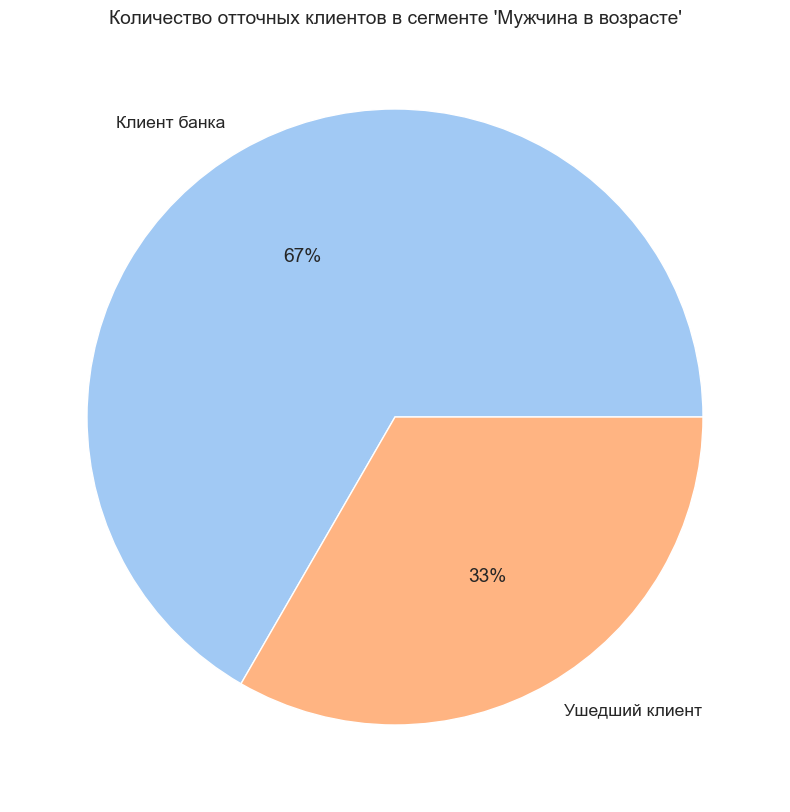

In [71]:
colors = sns.color_palette('pastel')[ 0:5 ]
labels = ['Клиент банка', 'Ушедший клиент']
plt.title("Количество отточных клиентов в сегменте 'Мужчина в возрасте'")
plt.pie(bc_old_m_pivot['count'],labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

Сегмент определен верно, уровень оттока в 33% внутри сегмента на 15% выше, чем уровень оттока по банку

#### Сегмент "Вовлеченный клиент"

- Признак: products и last_activity
- Интервал: (3,4) и 1 соответственно признакам
- Количество клиентов в сегменте: 824
- Количество отточных клиентов в сегменте: 391

In [72]:
bc_prod_activity = bc.query('products >=3 and last_activity == 1')

In [73]:
bc_prod_activity_pivot = bc_prod_activity.pivot_table(index='churn', values='score'
                             , aggfunc='count').reset_index().rename(columns={'score':'count'})
bc_prod_activity_pivot

,churn,count
0,0,433
1,1,391


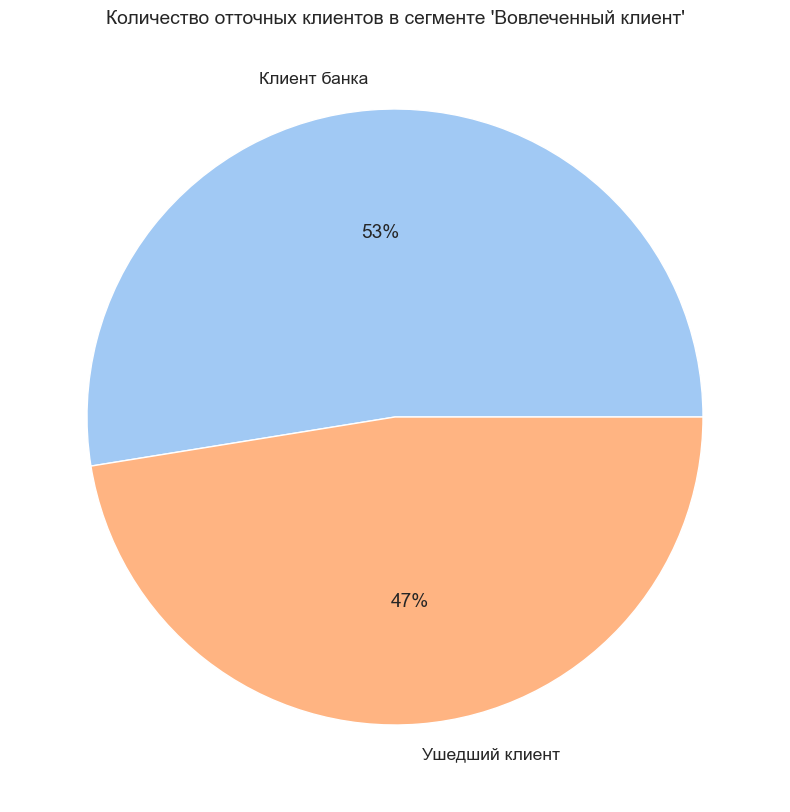

In [74]:
colors = sns.color_palette('pastel')[ 0:5 ]
labels = ['Клиент банка', 'Ушедший клиент']
plt.title("Количество отточных клиентов в сегменте 'Вовлеченный клиент'")
plt.pie(bc_prod_activity_pivot['count'],labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

Сегмент определен верно, уровень оттока в 47% внутри сегмента на 29% выше, чем уровень оттока по банку

#### Сегмент "Cберегательный"

- Признак: balance и est_salary
- Интервал: >1000 и (100-150) соответственно признакам
- Количество клиентов в сегменте: 528
- Количество отточных клиентов в сегменте: 194

In [75]:
bc_balance_sal = bc.query('est_salary >=100 and est_salary <=150 and balance >=1000')

In [76]:
bc_balance_sal_pivot = bc_balance_sal.pivot_table(index='churn', values='score'
                             , aggfunc='count').reset_index().rename(columns={'score':'count'})
bc_balance_sal_pivot

,churn,count
0,0,334
1,1,194


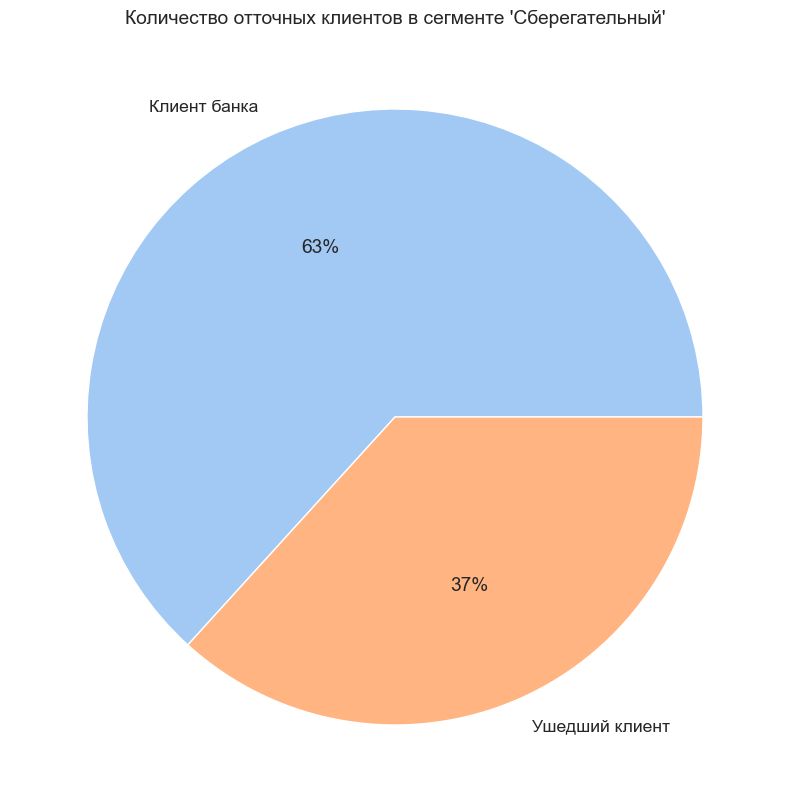

In [77]:
colors = sns.color_palette('pastel')[ 0:5 ]
labels = ['Клиент банка', 'Ушедший клиент']
plt.title("Количество отточных клиентов в сегменте 'Сберегательный'")
plt.pie(bc_balance_sal_pivot['count'],labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

Сегмент определен верно, уровень оттока в 37% внутри сегмента на 19% выше, чем уровень оттока по банку

#### Выводы по разделу

В данном разделе на основе ранее выявленных признаков и интервалов, нами сформированы 3 сегмента потенциально отточных клиентов, рассчитанный уровень оттока внутри каждого сегмента оказался значительно выше общебанковского уровня в 18%, что свидетельствует о достоверноости выбранных диапазонов и их влиянии на отток.

Сформированные сегменты:

- **"Мужчина в возрасте"** В данный сегмент вошли клиенты мужского пола в возрасте от 50 до 60 лет, исследовательский анализ данных явно указал что в этом сегменте склонность к оттоку выше, что подтверждает уровень оттока внутри сегмента в 33%
- **"Вовлеченный клиент"** В предварительном выводе мы отразили наблюдение о том что клиенты, активно пользующиеся продуктами банка, более склонны к оттоку, в данный сегмент помимо таких клиентов мы добавили клиентов имеющих более 3 продуктов, что прямо указывает на их заинтерисованность в услугах банка и их вовлеченность, уровень оттока составил 47%
- **"Сберегательный"** в данный сегмент по итогам исследования данных мы включили клиентов склонных к сбережениям, имеющих высокий баланс более 1000 на счете, при этом уровень заработной платы от 100 до 150, что является средним показателем для этого признака, уровень оттока внутри сегмента составил 37%

### Сформулировать выводы и дать рекомендации, которые могут помочь вернуть клиентов в банк или удержать сомневающихся от оттока

В итоговом выводе, резюмируем наблюдения которые последовательно нами были определены в ходе выполнения проекта.

Выяснено что, клиенты склонные к оттоку в целом выглядят для банка более качественными с точки зрения скоринговой оценки, у них выше баланс и зарабатная плата, а также они являются более активными пользователями своих продуктов, что может говорить о том, что состоятельные и заинтерисованные в услугах банка клиенты уходят в другой банк на лучшие условия. Являясь региональным банком, возможно мы проигрываем в привлекательности более крупным федеральным банкам.

Для работы по возвращению ушедших клиентов, а также удержанию сомневающихся, выявлены 3 сегмента отточных клиентов в порядке приоритета:

- **"Вовлеченный клиент"** В предварительном выводе мы отразили наблюдение о том что клиенты, активно пользующиеся продуктами банка, более склонны к оттоку, в данный сегмент помимо таких клиентов мы добавили клиентов имеющих более 3 продуктов, что прямо указывает на их заинтерисованность в услугах банка и их вовлеченность, **уровень оттока составил 47%**
- **"Сберегательный"** в данный сегмент по итогам исследования данных мы включили клиентов склонных к сбережениям, имеющих высокий баланс более 1000 на счете, при этом уровень заработной платы от 100 до 150, что является средним показателем для этого признака, **уровень оттока внутри сегмента составил 37%**
- **"Мужчина в возрасте"** В данный сегмент вошли клиенты мужского пола в возрасте от 50 до 60 лет, исследовательский анализ данных явно указал что в этом сегменте склонность к оттоку выше, что подтверждает **уровень оттока внутри сегмента в 33%**

Ниже предоставляю рекомендации, которые могут заинтерисовать клиентов каждого из сегментов:

**"Вовлеченный клиент"** Клиент являющийся активным пользователем услуг финансового сектора, может быть заинтерисован в расширении этих услуг или скорости их предостовления. Можно запустить рекламную акцию, с уникальным предложением для клиентов этого сегмента: Для возможности иметь оперативный доступ к новым заемным деньгам, теперь не потребуется тратить время на оформление новой кредитой линии, ведь для клиентов этого сегмента доступен беспроцентрый овердрафт в размере 1 млн рублей и сроком 6 месяцев.

**"Сберегательный"** Клиенты этого сегмента умеют считать деньги, склонны к сбережениям, их может заинтерисовать любая дополнительная выгода. Отлично подойдет предложение: При обслуживании счета в нашем банке, вы получаете кешбек в размере 1% от всех расходных операций по счету, дополнительно можно подключить к программе 1 ближайшего родственника бесплатно (муж/жена/дети), ему будет начисляться 0.5% от всех расходных операций по вашему счету, не зависимо от уже выплаченного вам кешбека

**"Мужчина в возрасте"** Клиентам в возрасте, когда финансовый вопрос может уступить место, заботе и вниманию, может быть интересна услуга от нашего партнера "Мобилка" - при оформелении любого нового продукта в нашем банке, предоставляется услуга бесплатные звонки на номера родственников сроком на 1 год